In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from medvqa.utils.files import load_pickle
from medvqa.evaluation.plots import plot_metrics, visualize_image_and_polygons
import numpy as np
import medvqa
import os
from importlib import reload
from medvqa.evaluation.plots import visualize_predicted_bounding_boxes__yolo
from medvqa.utils.constants import VINBIG_BBOX_NAMES
from medvqa.metrics.bbox.utils import compute_mAP__yolov11
from medvqa.utils.logging import print_magenta

In [76]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

In [3]:
# source: https://www.kaggle.com/competitions/vinbigdata-chest-xray-abnormalities-detection/data
VINBIGDATA_CHALLENGE_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
]
assert all(x in VINBIG_BBOX_NAMES for x in VINBIGDATA_CHALLENGE_CLASSES)

# source: https://github.com/philip-mueller/chex/blob/main/conf/dataset/class_names/vindrcxr_loc_top15.yaml
CHEX_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Cardiomegaly',
    'Calcification',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Mediastinal shift',
    'Nodule/Mass',
    'Pulmonary fibrosis',
    'Pneumothorax',
    'Pleural thickening',
    'Pleural effusion',
    'Other lesion',
]
assert all(x in VINBIG_BBOX_NAMES for x in CHEX_CLASSES)

# from https://arxiv.org/pdf/2401.10815 (Table 1)
RAD_DINO_CLASSES = [
    'Lung Opacity',
    'Cardiomegaly',
    'Pleural thickening',
    'Aortic enlargement',
    'Pulmonary fibrosis',
    'Tuberculosis',
    'Pleural effusion',
]

ALL_VINBIG_CLASSES = VINBIG_BBOX_NAMES + ['COPD', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other disease', 'No finding']

CHEX_IOU_THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [101]:
ALL_VINBIG_CLASSES

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Clavicle fracture',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Enlarged PA',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Lung cavity',
 'Lung cyst',
 'Mediastinal shift',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis',
 'Rib fracture',
 'COPD',
 'Lung tumor',
 'Pneumonia',
 'Tuberculosis',
 'Other disease',
 'No finding']

In [4]:
def compute_map_metrics_from_results(results_path, iou_thresholds = [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    results = load_pickle(results_path)
    res = compute_mAP__yolov11(
        gt_coords=results['gt_bboxes'],
        pred_boxes=results['pred_boxes_list'],
        pred_classes=results['pred_classes_list'],
        pred_confs=results['pred_confs_list'],
        classifier_confs=results['classifier_confs'],
        iou_thresholds=iou_thresholds,
        compute_micro_average=True,
    )
    class_aps = res['class_aps']
    micro_aps = res['micro_aps']
        
    for iou_thresh, map_ in zip(iou_thresholds, class_aps.mean(axis=1)):
        print_magenta(f'mAP@{iou_thresh}: {map_}', bold=True)

    for iou_thresh, ap in zip(iou_thresholds, micro_aps):
        print_magenta(f'micro_AP@{iou_thresh}: {ap}', bold=True)
        
    # vinbigdata metric
    class_idxs = [VINBIG_BBOX_NAMES.index(x) for x in VINBIGDATA_CHALLENGE_CLASSES]
    iou_idx = iou_thresholds.index(0.4)
    mAP = class_aps[iou_idx, class_idxs].mean()
    print_magenta(f'vinbigdata mAP@0.4: {mAP}', bold=True)

    # ChEX metric
    class_idxs = [VINBIG_BBOX_NAMES.index(x) for x in CHEX_CLASSES]
    iou_idxs = [iou_thresholds.index(x) for x in CHEX_IOU_THRESHOLDS]
    mAP = class_aps[iou_idxs][:, class_idxs].mean()
    print_magenta(f'ChEX mAP@{CHEX_IOU_THRESHOLDS}: {mAP}', bold=True)
    
    # Rad-DINO AUPRC
    print('--- RAD-DINO AUPRC ---')
    prc_auc_per_class = results['prc_auc']['per_class']
    class_idxs = [ALL_VINBIG_CLASSES.index(x) for x in RAD_DINO_CLASSES]
    acc = 0
    count = 0
    for idx, name in zip(class_idxs, RAD_DINO_CLASSES):
        print_magenta(f'AUPRC({name}): {prc_auc_per_class[idx]}', bold=True)
        acc += prc_auc_per_class[idx]
        count += 1
    print_magenta(f'AUPRC(macro average): {acc / count}', bold=True)

# 1) Phrase Grounding: DenseNet121 + CXRFE + Sigmoid-based attention

In [9]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_feature_extra

In [11]:
tmp1 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/vindrcxr_metrics.pkl')

In [129]:
tmp = tmp1

In [130]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

posx and posy should be finite values


posx and posy should be finite values


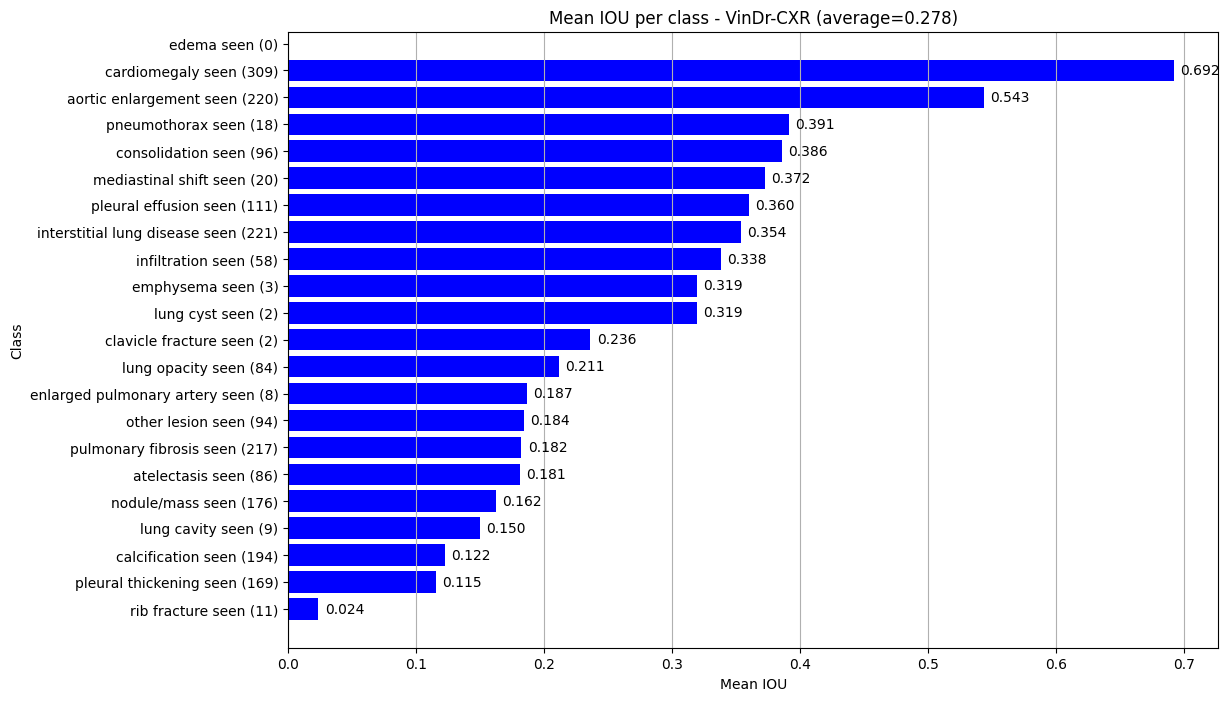

In [131]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [19]:
from medvqa.evaluation.plots import visualize_attention_maps

In [49]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [77]:
# idx = idxs[-200]
idx = idxs[200]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.7070717811584473

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/889347926c284c6c61234b357153d327.jpg

interstitial lung disease seen


In [26]:
from medvqa.datasets.vinbig import load_test_image_id_2_bboxes, visualize_image_with_bounding_boxes
test_image_id_2_bboxes = load_test_image_id_2_bboxes()

Anomalous bboxes found: 0 of 2697


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/889347926c284c6c61234b357153d327.jpg
0: ILD
[[335.2509977817093, 551.816172253801, 788.6113235322391, 1605.0496119547272], [1269.6155715846303, 485.4707587293333, 1753.3842118672085, 1563.5837285019347]]


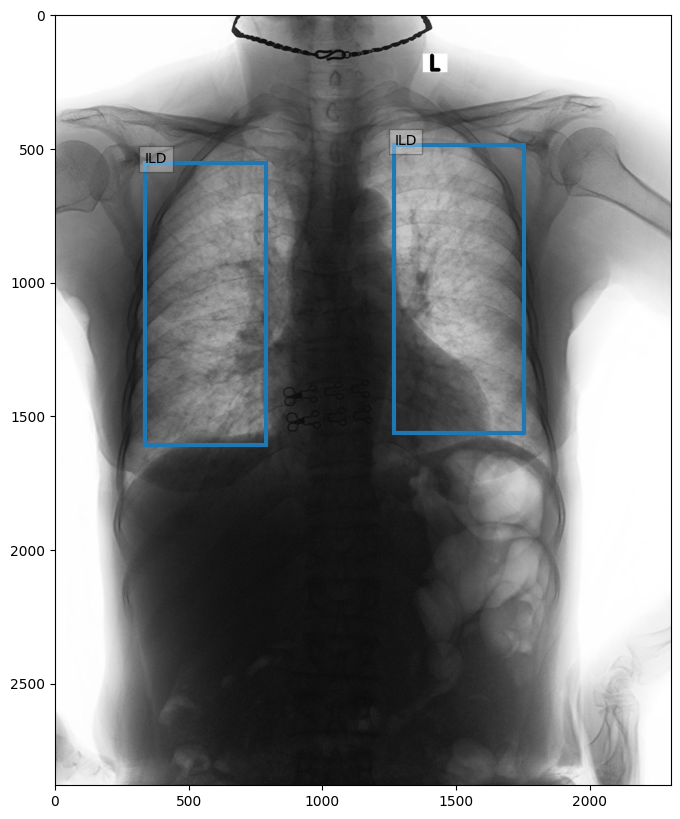

In [78]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

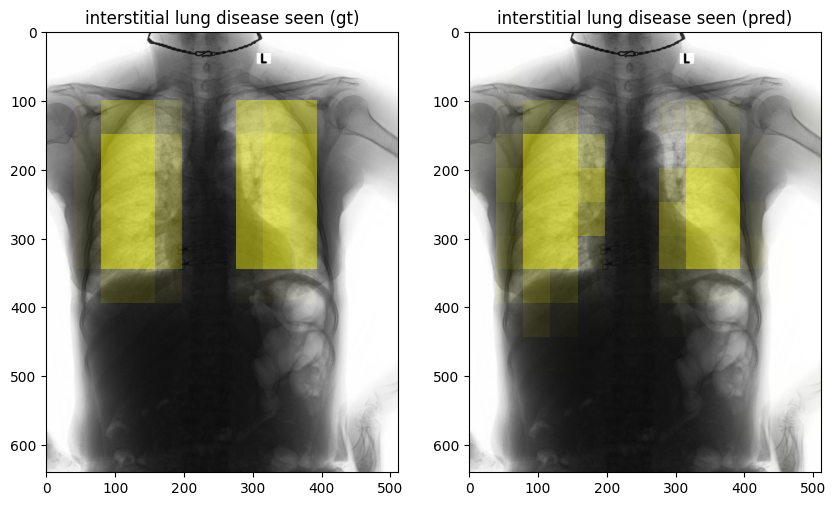

In [79]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

# 2) Phrase Grounding: DenseNet121 + CXRFE + Transformer Encoder

In [80]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_featu

# 3) Phrase Grounding: DenseNet121 + CXRFE + FiLM-based attention

In [81]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-12

In [82]:
tmp3 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)/vindrcxr_metrics.pkl')

In [126]:
tmp = tmp3

In [127]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

posx and posy should be finite values


posx and posy should be finite values


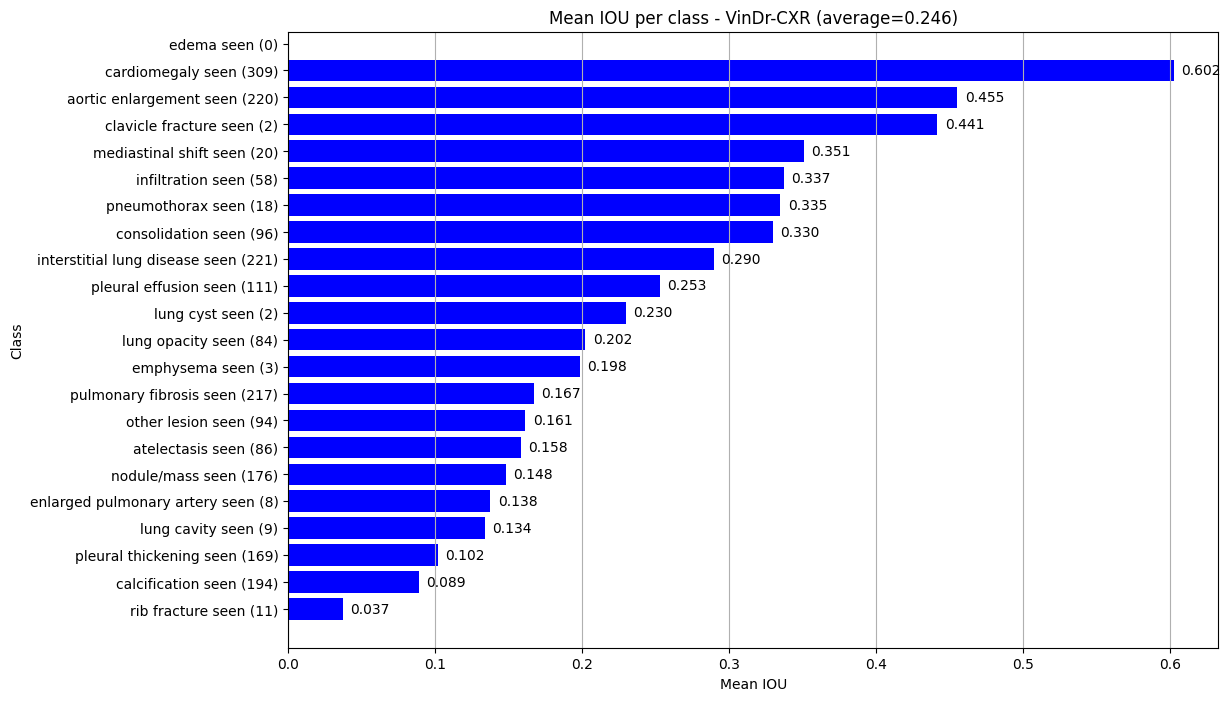

In [128]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [87]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [116]:
# idx = idxs[-200]
idx = idxs[-500]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.06893625110387802

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/b856f3db2491d631aa4300206b97ff82.jpg

pulmonary fibrosis seen


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/b856f3db2491d631aa4300206b97ff82.jpg
0: ILD
[[456.8576358404049, 1316.1147173953464, 1046.6127684311336, 1896.35767042816]]
1: Nodule/Mass
[[725.2047387729664, 1460.8034860750136, 1043.8627539631182, 1734.278648365069]]
2: Pleural effusion
[[335.5773464769885, 1630.0166428065406, 689.9060350093217, 1939.1624784387773]]
3: Pleural thickening
[[2085.442266866496, 1979.2380226523337, 2181.980020369589, 2239.889957110689]]
4: Pulmonary fibrosis
[[418.8089176087447, 1194.8344280319302, 789.7839203674289, 1356.541480516485]]


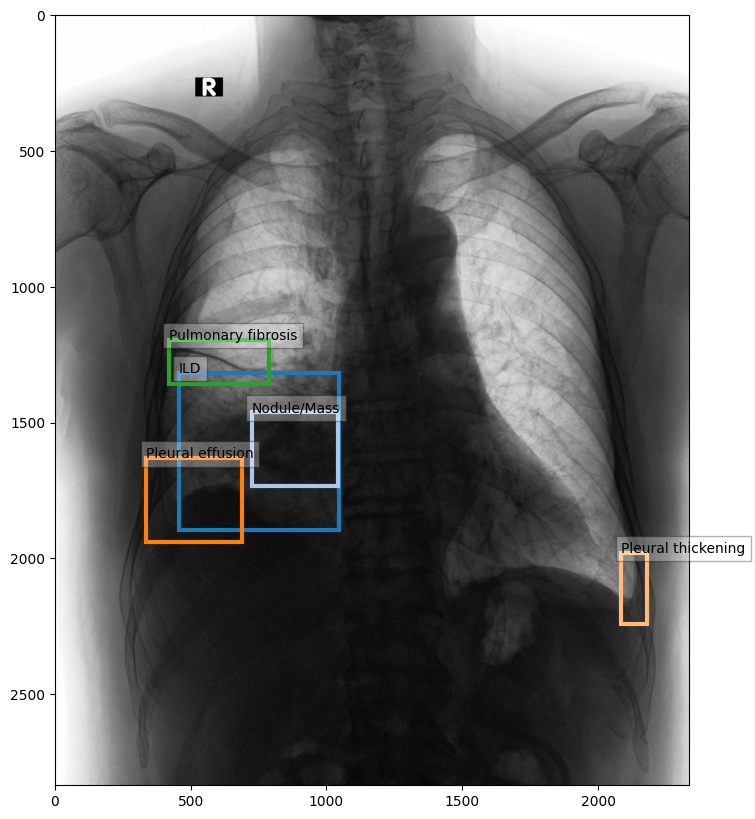

In [117]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

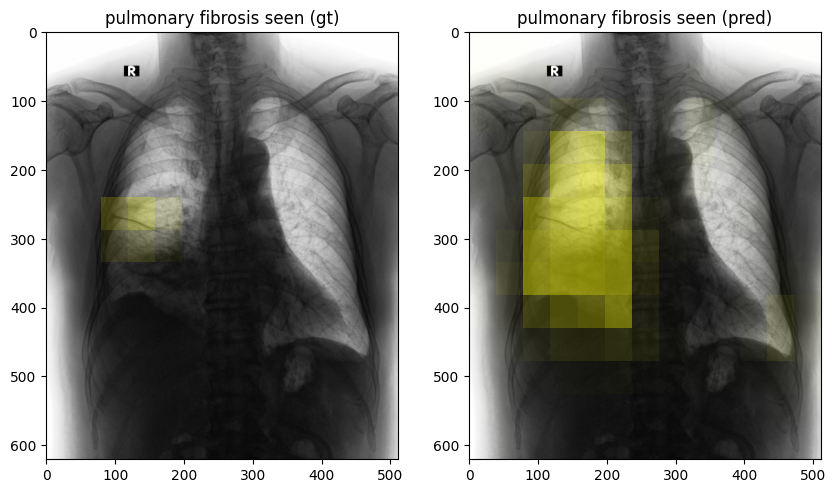

In [118]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

In [90]:
from medvqa.datasets.vinbig import load_train_image_id_2_bboxes

In [91]:
train_image_id_2_bboxes = load_train_image_id_2_bboxes()

Anomalous bboxes found: 0 of 37367


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/0007d316f756b3fa0baea2ff514ce945.jpg
0: Aortic enlargement
[[1275.2900390625, 1039.9000244141, 1498.7099609375, 1241.6199951172], [1235.9799804688, 1021.6400146484, 1482.9000244141, 1281.9799804688]]
1: Cardiomegaly
[[902.03997802734, 1827.7399902344, 1829.6700439453, 2037.0200195312]]
2: ILD
[[1847.3100585938, 1409.9899902344, 2093.1201171875, 2096.5500488281], [535.40399169922, 1748.9799804688, 932.21997070312, 2013.0600585938]]
3: Pleural thickening
[[818.666015625, 677.09802246094, 987.66998291016, 939.34497070312], [621.36499023438, 673.40600585938, 1025.8599853516, 851.7340087890599], [790.0479736328099, 634.90301513672, 1047.8399658203, 725.0390014648401]]
4: Pulmonary fibrosis
[[818.666015625, 677.09802246094, 987.66998291016, 939.34497070312], [804.0040283203099, 716.57000732422, 857.5239868164099, 920.35797119141], [1392.7199707031, 702.15997314453, 1518.2900390625, 790.67401123047]]


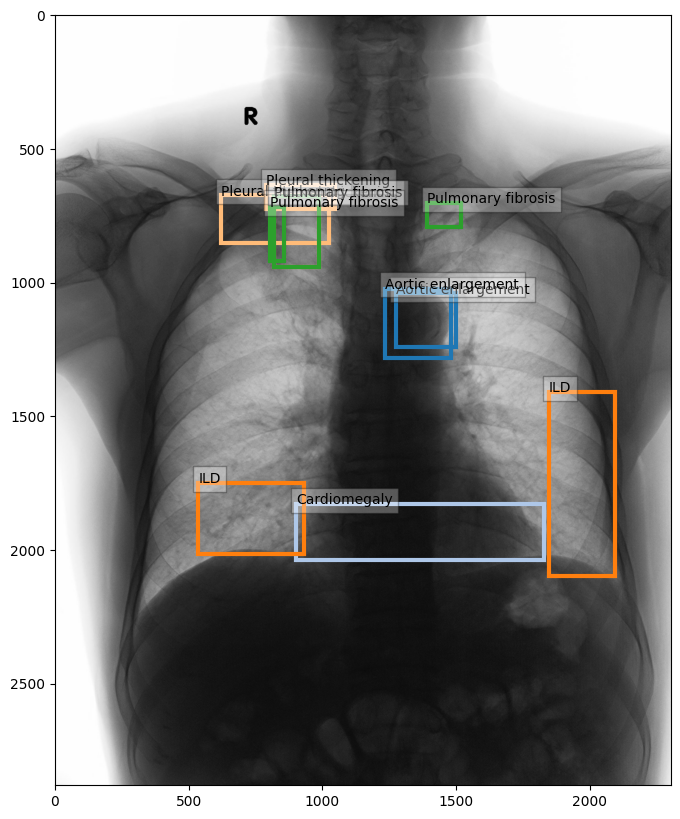

In [11]:
key = os.path.basename('/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/0007d316f756b3fa0baea2ff514ce945.jpg')[:-4]
visualize_image_with_bounding_boxes(key, train_image_id_2_bboxes[key], verbose=True)

# 4) Phrase Grounding: DN121+CXRFE+FiLM+bbox (VinDR-CXR)

In [75]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPu

In [314]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounde

conf_th=0.2, iou_th=0.3, mAP=0.1589726362394991 (time_input_processing=1.8959667682647705, time_map=3.063363552093506)
conf_th=0.2, iou_th=0.4, mAP=0.15851107845651716 (time_input_processing=1.9004037380218506, time_map=3.484243392944336)
conf_th=0.2, iou_th=0.5, mAP=0.1540548961216925 (time_input_processing=2.158745050430298, time_map=4.115062475204468)
conf_th=0.3, iou_th=0.02, mAP=0.1552950837733238 (time_input_processing=1.8517069816589355, time_map=2.000192880630493)
conf_th=0.3, iou_th=0.05, mAP=0.15525899889389516 (time_input_processing=1.8519091606140137, time_map=2.050588607788086)
conf_th=0.3, iou_th=0.1, mAP=0.15621570737880364 (time_input_processing=1.8479290008544922, time_map=2.151925802230835)
conf_th=0.3, iou_th=0.2, mAP=0.15481551566131488 (time_input_processing=2.108630895614624, time_map=2.4268438816070557)
conf_th=0.3, iou_th=0.3, mAP=0.15888257568099867 (time_input_processing=1.8540863990783691, time_map=2.760392427444458)
conf_th=0.3, iou_th=0.4, mAP=0.15845454414

In [52]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241128_153116_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.30,0.40,50),use_classifier_confs).pkl')

mAP@0.0: 0.2897951782120265
mAP@0.02: 0.24109310797489647
mAP@0.05: 0.2221399704063156
mAP@0.1: 0.1903686730162686
mAP@0.2: 0.14083659008877594
mAP@0.3: 0.11730951307615438
mAP@0.4: 0.09665405579539231
mAP@0.5: 0.07596140180488084
mAP@0.6: 0.05862090089547241
mAP@0.7: 0.042644597958426685
micro_AP@0.0: 0.40431341033366697
micro_AP@0.02: 0.3708038685016486
micro_AP@0.05: 0.34551120225159165
micro_AP@0.1: 0.30354943661943745
micro_AP@0.2: 0.2472684429412056
micro_AP@0.3: 0.20734579123003638
micro_AP@0.4: 0.17593476477066627
micro_AP@0.5: 0.13837399425249688
micro_AP@0.6: 0.09775810611428801
micro_AP@0.7: 0.054267491388075365
vinbigdata mAP@0.4: 0.14441048881585633
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.1476147000138287
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.1219809797831717
AUPRC(Cardiomegaly): 0.7499758899081197
AUPRC(Pleural thickening): 0.39012571091440157
AUPRC(Aortic enlargement): 0.4063326443180025
AUPRC(Pulmonary fibrosis): 0.4815191156385418
AUPRC(Tuberculosis): 0

In [109]:
tmp = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

In [110]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_bboxes', 'gt_bboxes', 'ious', 'bbox_iou', 'prc_auc'])

In [141]:
from medvqa.utils.files import get_cached_pickle_file
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

def iou_macro_average(metrics_path):
    tmp = get_cached_pickle_file(metrics_path)
    phrase2idxs = { x:[] for x in vinbig_phrases }
    for idx, phrase in enumerate(tmp['phrases']):
        phrase2idxs[phrase].append(idx)
    
    count = 0
    acc_iou = 0
    for idxs in phrase2idxs.values():
        if len(idxs) > 0:
            acc_iou += np.mean([tmp['ious'][idx] for idx in idxs])
            count += 1
    assert count > 0
    return acc_iou / count

In [142]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.16353653144077654

/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values


posx and posy should be finite values


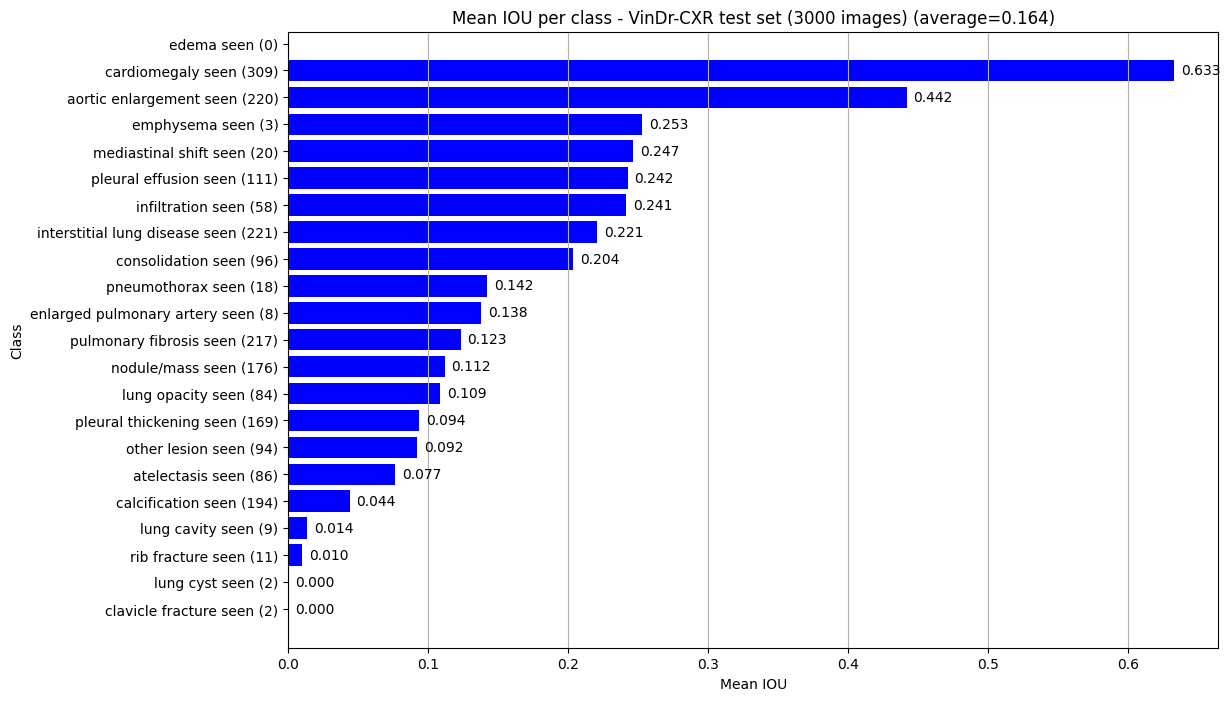

In [117]:


vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [68]:
reload(medvqa.datasets.vinbig)

<module 'medvqa.datasets.vinbig' from '/home/pamessina/medvqa/medvqa/datasets/vinbig/__init__.py'>

In [69]:
from medvqa.datasets.vinbig import compute_label_frequencies

In [70]:
label_frequencies = compute_label_frequencies()

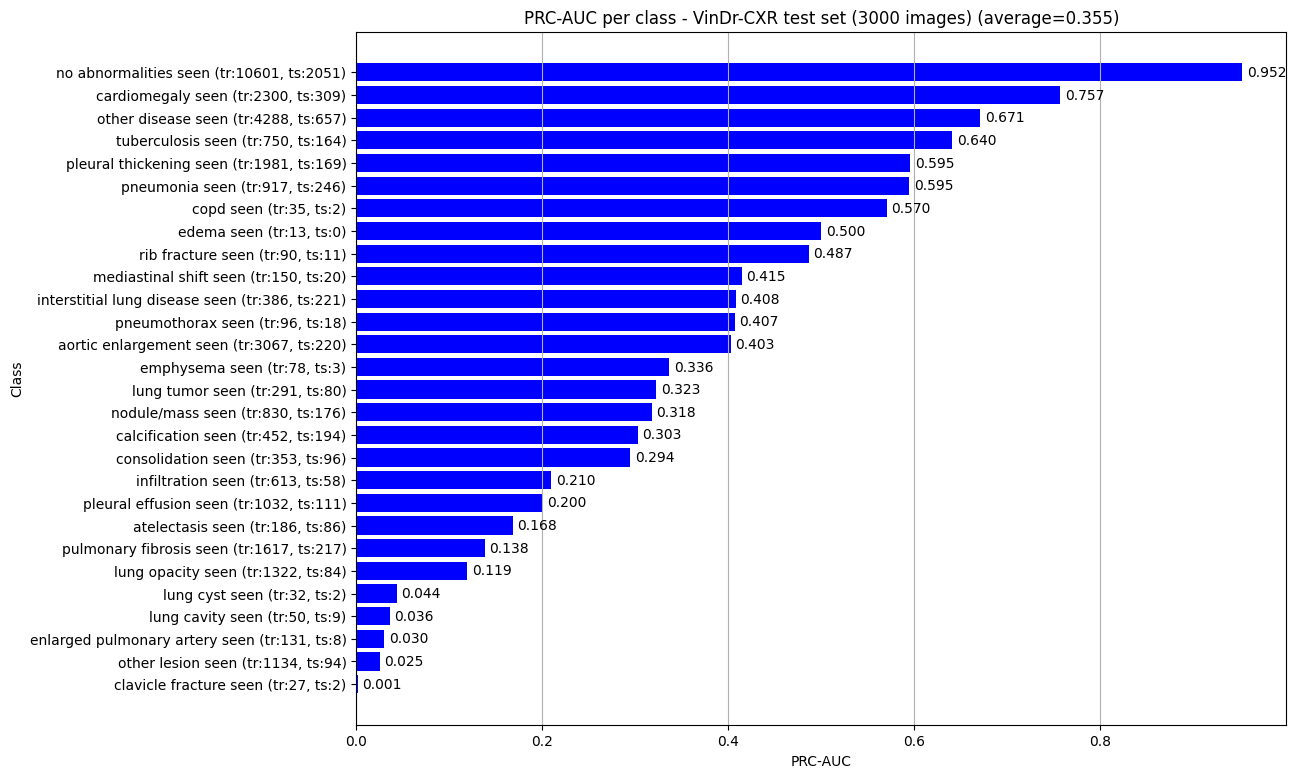

In [118]:
from medvqa.utils.constants import VINBIG_LABELS, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_LABELS],
    metric_values=tmp['prc_auc']['per_class'],
    title='PRC-AUC per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

In [119]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [133]:
idx = idxs[-10]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0

/mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/c28e30456f3d1b1dda8a22f958b7aa96.jpg

consolidation seen


image_path: /mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images/c28e30456f3d1b1dda8a22f958b7aa96.jpg
0: Consolidation
[[1234.2674134950737, 1197.0789112898806, 1561.2234809904303, 1504.8022689325694]]


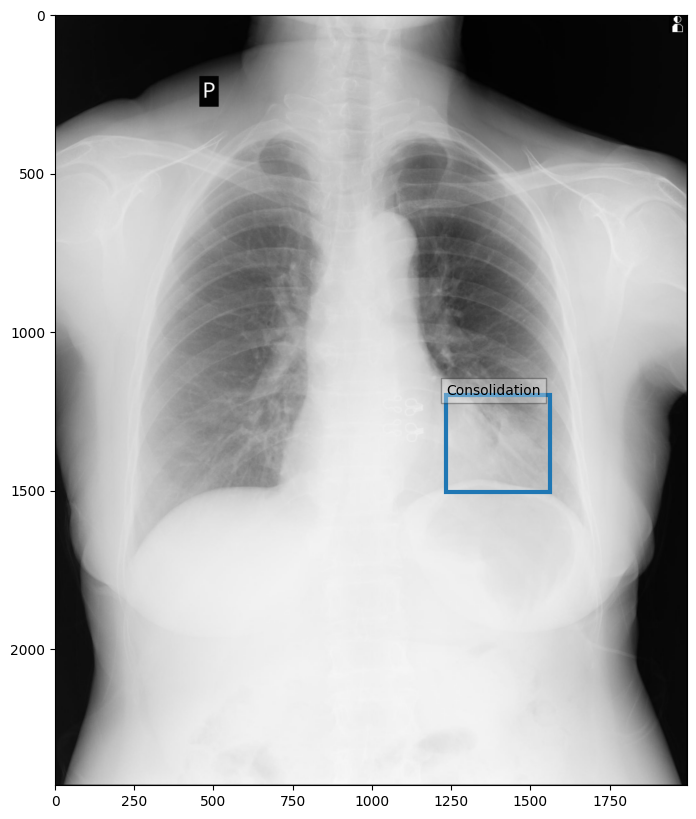

In [134]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

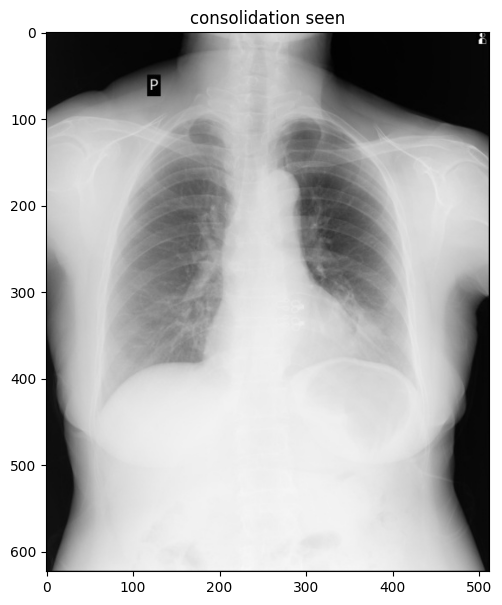

In [135]:
from medvqa.evaluation.plots import visualize_visual_grounding_as_bboxes
visualize_visual_grounding_as_bboxes(
    image_path=tmp['image_paths'][idx],
    phrases=[tmp['phrases'][idx]],
    bboxes=[tmp['pred_bboxes'][idx]] if tmp['pred_bboxes'][idx] is not None else [[]],
    figsize=(7, 7),
    max_cols=1,
)

In [74]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig \
--vinbig_use_training_indices_for_validation

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPur

In [76]:
tmp2 = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression).pkl")

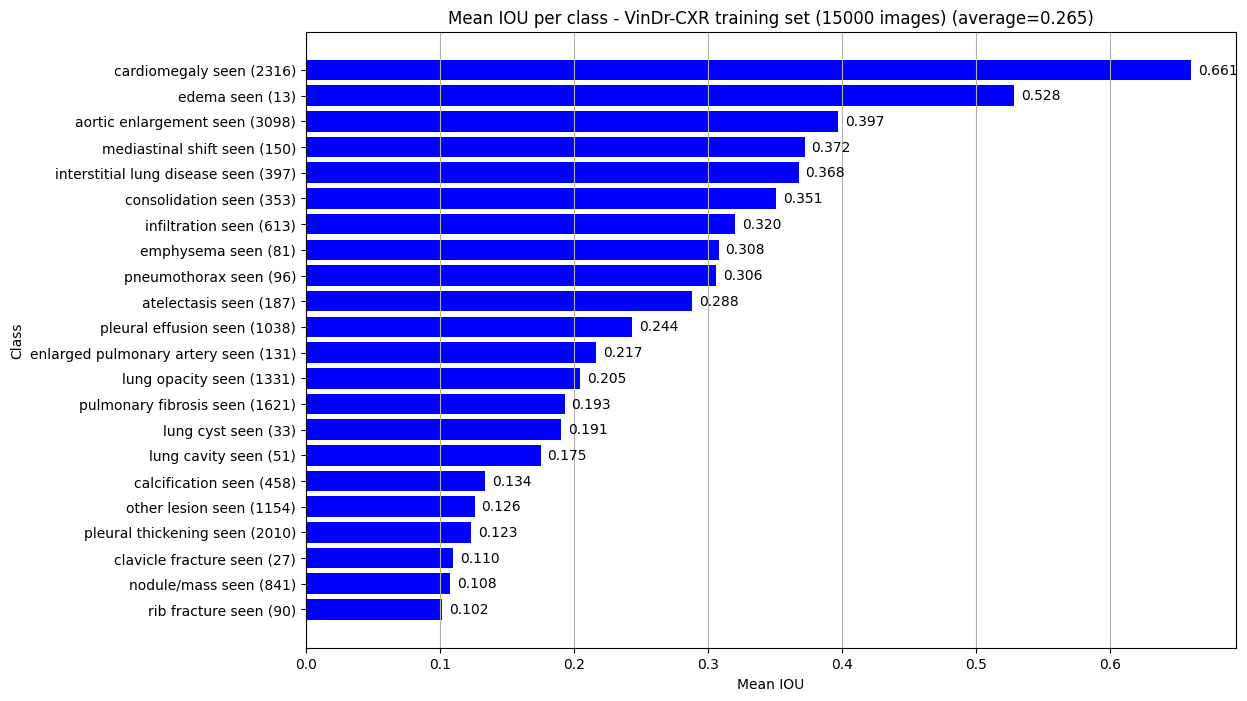

In [81]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp2['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp2['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR training set (15000 images)',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

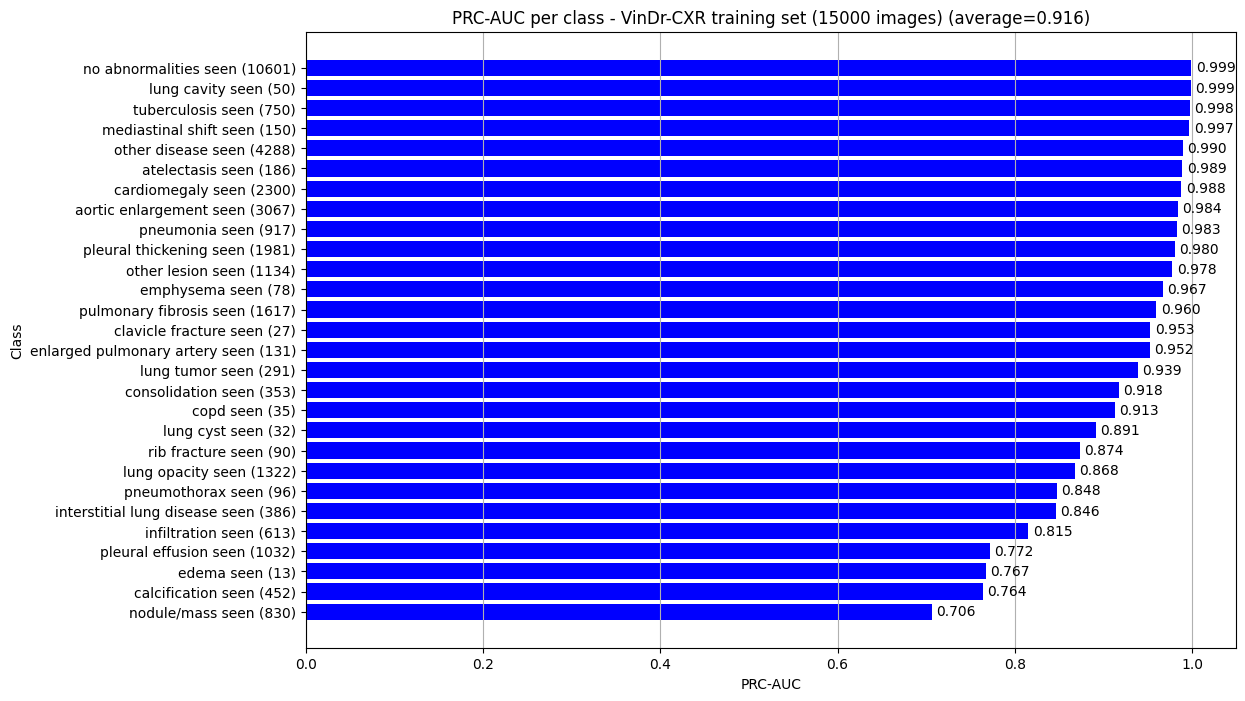

In [83]:
plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} ({label_frequencies["train"][x]})' for x in VINBIG_LABELS],
    metric_values=tmp2['prc_auc']['per_class'],
    title='PRC-AUC per class - VinDr-CXR training set (15000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [86]:
idxs = np.argsort(tmp2['ious'])[::-1]
len(idxs)

16089

In [104]:
idx = idxs[-1000]
print(tmp2['ious'][idx])
print()
print(tmp2['image_paths'][idx])
print()
print(tmp2['phrases'][idx])

0.01016150708654602

/mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/afb41a2217d37b54f0427fc1c69336be.jpg

pulmonary fibrosis seen


image_path: /mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images/afb41a2217d37b54f0427fc1c69336be.jpg
0: Consolidation
[[702.4110107421901, 1225.1600341797, 1186.9799804688, 1614.6899414062]]
1: Infiltration
[[645.81799316406, 1281.3299560547, 1115.6899414062, 1657.7900390625], [670.5830078125, 1128.7399902344, 1167.3100585938, 1650.1600341797]]
2: Lung Opacity
[[670.5830078125, 1128.7399902344, 1167.3100585938, 1650.1600341797]]
3: Pleural thickening
[[904.57000732422, 345.76998901367006, 1203.4699707031, 500.55499267578006]]
4: Pulmonary fibrosis
[[781.3980102539099, 814.30200195312, 852.4520263671901, 880.28100585938]]


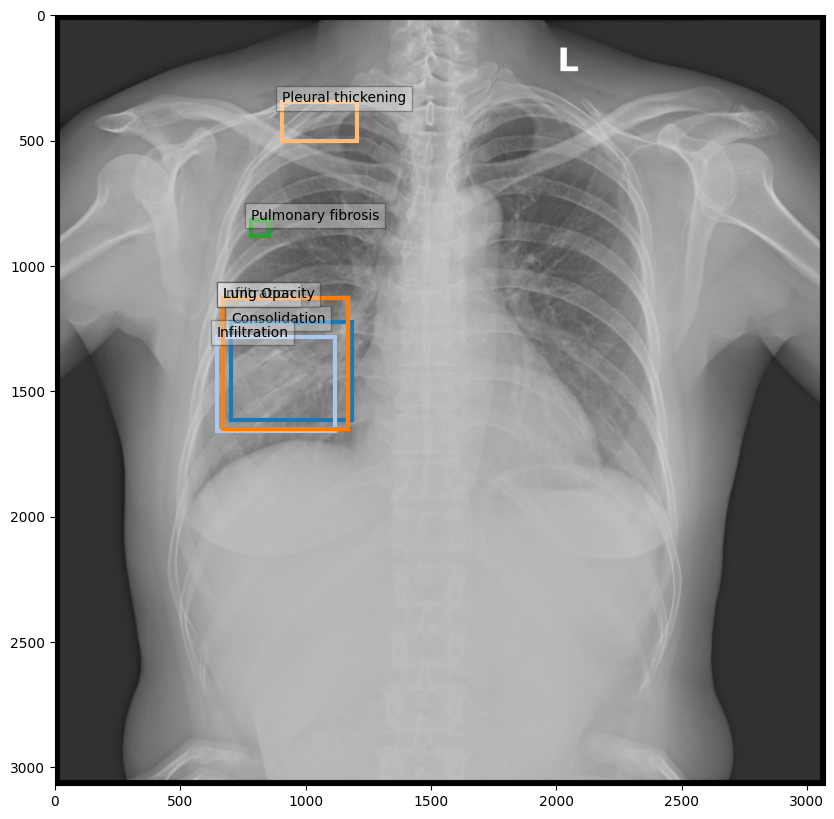

In [105]:
key = os.path.basename(tmp2['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, train_image_id_2_bboxes[key], verbose=True)

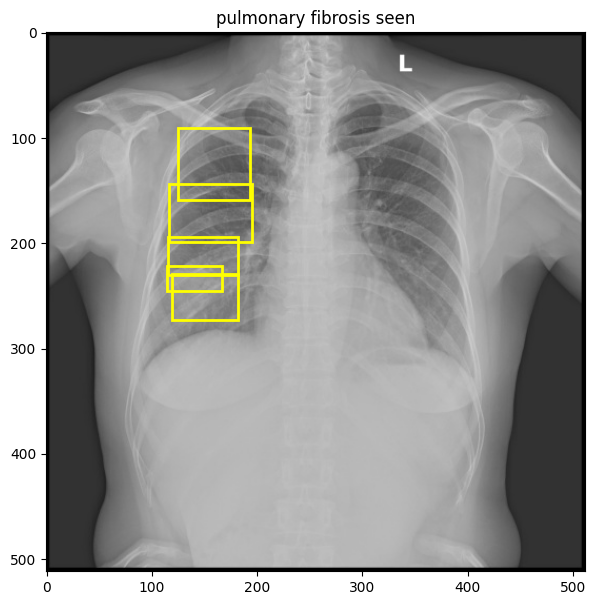

In [106]:
from medvqa.evaluation.plots import visualize_visual_grounding_as_bboxes
visualize_visual_grounding_as_bboxes(
    image_path=tmp2['image_paths'][idx],
    phrases=[tmp2['phrases'][idx]],
    bboxes=[tmp2['pred_bboxes'][idx]] if tmp2['pred_bboxes'][idx] is not None else [[]],
    figsize=(7, 7),
    max_cols=1,
)

# 5) Phrase Grounding: DN121+CXRFE+FiLM+bbox; Chest ImaGenome + VinDR-CXR

In [107]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance o

In [143]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.14017660799139942

In [311]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-

conf_th=0.2, iou_th=0.2, mAP=0.10186465944381569 (time_input_processing=2.0248382091522217, time_map=3.0251171588897705)
conf_th=0.2, iou_th=0.3, mAP=0.10082598605000724 (time_input_processing=2.2953073978424072, time_map=3.6223721504211426)
conf_th=0.2, iou_th=0.4, mAP=0.10095420678776504 (time_input_processing=1.996204137802124, time_map=4.403188943862915)
conf_th=0.2, iou_th=0.5, mAP=0.10026306132685069 (time_input_processing=2.000032901763916, time_map=5.68297815322876)
conf_th=0.3, iou_th=0.02, mAP=0.10402990990329891 (time_input_processing=1.9782485961914062, time_map=2.2034034729003906)
conf_th=0.3, iou_th=0.05, mAP=0.10292990271491692 (time_input_processing=1.9743216037750244, time_map=2.554919719696045)
conf_th=0.3, iou_th=0.1, mAP=0.10264670320115897 (time_input_processing=1.9792866706848145, time_map=2.438201665878296)
conf_th=0.3, iou_th=0.2, mAP=0.10095572911671041 (time_input_processing=1.9816555976867676, time_map=3.1297547817230225)
conf_th=0.3, iou_th=0.3, mAP=0.100807

In [54]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.22218019263421496
mAP@0.02: 0.1535871067957074
mAP@0.05: 0.1420744101822133
mAP@0.1: 0.1229553758480865
mAP@0.2: 0.09798163137624365
mAP@0.3: 0.08081227105958926
mAP@0.4: 0.06816064220268757
mAP@0.5: 0.05384833086379573
mAP@0.6: 0.04080402004842514
mAP@0.7: 0.032109578710220604
micro_AP@0.0: 0.2634950900270627
micro_AP@0.02: 0.21370652549997632
micro_AP@0.05: 0.20016152302727314
micro_AP@0.1: 0.17989601847601433
micro_AP@0.2: 0.1503661040743351
micro_AP@0.3: 0.13005369796820815
micro_AP@0.4: 0.10789931374352142
micro_AP@0.5: 0.07432640647343974
micro_AP@0.6: 0.04374982612508174
micro_AP@0.7: 0.0321709088380677
vinbigdata mAP@0.4: 0.09958735330587665
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.10311027162450978
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.11550298543152135
AUPRC(Cardiomegaly): 0.7129168037141862
AUPRC(Pleural thickening): 0.29630724532623404
AUPRC(Aortic enlargement): 0.3731598988755374
AUPRC(Pulmonary fibrosis): 0.388538776752407
AUPRC(Tuberculosis): 0.

# 6) Phrase Grounding: DN121+CXRFE+FiLM+bbox; Chest ImaGenome + VinDR-CXR + MIMIC-CXR (facts + GPT-4 labels)

In [136]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
---------------------

In [144]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.1521956186451413

In [310]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grou

conf_th=0.2, iou_th=0.05, mAP=0.11729295486746626 (time_input_processing=2.2565577030181885, time_map=2.727806329727173)
conf_th=0.2, iou_th=0.1, mAP=0.11633540051578728 (time_input_processing=1.9973723888397217, time_map=2.9368038177490234)
conf_th=0.2, iou_th=0.2, mAP=0.1165064511903442 (time_input_processing=1.9978480339050293, time_map=3.6885738372802734)
conf_th=0.2, iou_th=0.3, mAP=0.11885897020856935 (time_input_processing=2.0056300163269043, time_map=4.03694486618042)
conf_th=0.2, iou_th=0.4, mAP=0.11828319705039471 (time_input_processing=2.011373996734619, time_map=5.0844151973724365)
conf_th=0.2, iou_th=0.5, mAP=0.11993134284377654 (time_input_processing=2.013296127319336, time_map=5.771182060241699)
conf_th=0.3, iou_th=0.02, mAP=0.11857200594378878 (time_input_processing=1.9893605709075928, time_map=2.1964449882507324)
conf_th=0.3, iou_th=0.05, mAP=0.11694452796931384 (time_input_processing=2.0064337253570557, time_map=1.965209722518921)
conf_th=0.3, iou_th=0.1, mAP=0.116007

In [55]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.70,50),use_classifier_confs).pkl')

mAP@0.0: 0.25126326615389594
mAP@0.02: 0.1807348477495279
mAP@0.05: 0.16491040418330571
mAP@0.1: 0.14314264480591501
mAP@0.2: 0.11692658133294072
mAP@0.3: 0.09138503821253369
mAP@0.4: 0.07857715744941894
mAP@0.5: 0.07050439854197334
mAP@0.6: 0.05918951588955705
mAP@0.7: 0.04535414112797207
micro_AP@0.0: 0.28297186753065195
micro_AP@0.02: 0.23320766465507828
micro_AP@0.05: 0.2137991623499704
micro_AP@0.1: 0.18824719009836827
micro_AP@0.2: 0.15423983621935305
micro_AP@0.3: 0.12190127191331569
micro_AP@0.4: 0.10313516584377247
micro_AP@0.5: 0.09100580747792825
micro_AP@0.6: 0.07093458979247995
micro_AP@0.7: 0.04689065039264152
vinbigdata mAP@0.4: 0.1204036632421954
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.12568708272094092
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.10241995855421374
AUPRC(Cardiomegaly): 0.7943512747304231
AUPRC(Pleural thickening): 0.29459611852607753
AUPRC(Aortic enlargement): 0.39661944768033947
AUPRC(Pulmonary fibrosis): 0.400326951478344
AUPRC(Tuberculosis):

# 7) DN121+CXRFE+Global Pooling+FiLM+MLP; VinDR-CXR

In [315]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)/metadata.json
do_visual_grounding_with_bbox_

# 8) DN121+CXRFE+Global Pooling+Concat+MLP; VinDR-CXR

In [316]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)/metadata.json
do_visual_grounding_with_b

# 9) DN121+CXRFE+FiLM Attention Pooling+MLP; VinDR-CXR

In [317]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_

# 10) DN121+CXRFE+Transformer (classif. only); VinDR-CXR

In [318]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)/metadata.json
do

# 11) DN121+CXRFE+Transformer+BBox+Classif; VinDR-CXR

In [153]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance

In [154]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.11413830329169078

In [300]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121

conf_th=0.2, iou_th=0.5, mAP=0.13563813367743507 (time_input_processing=1.627943992614746, time_map=3.676935911178589)
conf_th=0.3, iou_th=0.02, mAP=0.13381928159178055 (time_input_processing=1.5815846920013428, time_map=1.7964768409729004)
conf_th=0.3, iou_th=0.05, mAP=0.13462077119040838 (time_input_processing=1.5820250511169434, time_map=1.8527426719665527)
conf_th=0.3, iou_th=0.1, mAP=0.13446295206118516 (time_input_processing=1.583618402481079, time_map=1.9590041637420654)
conf_th=0.3, iou_th=0.2, mAP=0.13435236082749438 (time_input_processing=1.5865767002105713, time_map=2.478414297103882)
conf_th=0.3, iou_th=0.3, mAP=0.13434030622361456 (time_input_processing=1.5894546508789062, time_map=2.5690228939056396)
conf_th=0.3, iou_th=0.4, mAP=0.13561769240547508 (time_input_processing=1.5823071002960205, time_map=2.916461706161499)
conf_th=0.3, iou_th=0.5, mAP=0.1352255173634387 (time_input_processing=1.593003273010254, time_map=3.3357887268066406)
conf_th=0.4, iou_th=0.02, mAP=0.13269

In [56]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.28309233683319446
mAP@0.02: 0.22511022671478464
mAP@0.05: 0.19950404488953924
mAP@0.1: 0.16666205261935124
mAP@0.2: 0.12268325782516877
mAP@0.3: 0.09968534746244771
mAP@0.4: 0.07473495099587137
mAP@0.5: 0.0610739004059752
mAP@0.6: 0.044258883435927314
mAP@0.7: 0.035168979406193165
micro_AP@0.0: 0.38468460300338925
micro_AP@0.02: 0.34235446145873516
micro_AP@0.05: 0.3088394194556979
micro_AP@0.1: 0.2670651628459709
micro_AP@0.2: 0.20792149449197664
micro_AP@0.3: 0.1643169866814061
micro_AP@0.4: 0.13194025646855645
micro_AP@0.5: 0.10266535012644226
micro_AP@0.6: 0.06678538977646775
micro_AP@0.7: 0.04094833197764323
vinbigdata mAP@0.4: 0.11577699404415465
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.12176259381314564
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.13349666613528569
AUPRC(Cardiomegaly): 0.6992298937039946
AUPRC(Pleural thickening): 0.38200082138457714
AUPRC(Aortic enlargement): 0.38585632031065986
AUPRC(Pulmonary fibrosis): 0.4714701032974937
AUPRC(Tuberculosis

# 12) aehrc-cxrmate-rrg24-uniformer+CXRFE+Transformer+BBox+Classif; VinDR-CXR

In [155]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
-----------------------

In [156]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.14304222217816195

In [298]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vin

conf_th=0.2, iou_th=0.5, mAP=0.19441760859015955 (time_input_processing=1.4390716552734375, time_map=3.0499114990234375)
conf_th=0.3, iou_th=0.02, mAP=0.189575620863787 (time_input_processing=1.408747673034668, time_map=1.507448434829712)
conf_th=0.3, iou_th=0.05, mAP=0.19166873431996712 (time_input_processing=1.4025530815124512, time_map=1.551276445388794)
conf_th=0.3, iou_th=0.1, mAP=0.19370217158897038 (time_input_processing=1.4056627750396729, time_map=1.6593258380889893)
conf_th=0.3, iou_th=0.2, mAP=0.19292409185586742 (time_input_processing=1.4069797992706299, time_map=1.7942376136779785)
conf_th=0.3, iou_th=0.3, mAP=0.19622181776683084 (time_input_processing=1.4070916175842285, time_map=1.9996514320373535)
conf_th=0.3, iou_th=0.4, mAP=0.1946834887641203 (time_input_processing=1.4036262035369873, time_map=2.257585287094116)
conf_th=0.3, iou_th=0.5, mAP=0.19420019698810675 (time_input_processing=1.4079680442810059, time_map=2.5842959880828857)
conf_th=0.4, iou_th=0.02, mAP=0.18848

In [58]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.30,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.34269842073246165
mAP@0.02: 0.3187746008320953
mAP@0.05: 0.29024189263928474
mAP@0.1: 0.2529910913321378
mAP@0.2: 0.1828452621689816
mAP@0.3: 0.13753497802555845
mAP@0.4: 0.10849279369268806
mAP@0.5: 0.08355606289481114
mAP@0.6: 0.0575064475256172
mAP@0.7: 0.03981577066097957
micro_AP@0.0: 0.44677907730310573
micro_AP@0.02: 0.41308522512773327
micro_AP@0.05: 0.3813122100472383
micro_AP@0.1: 0.329599029146572
micro_AP@0.2: 0.26319478431839105
micro_AP@0.3: 0.20923374110944154
micro_AP@0.4: 0.17275781536966484
micro_AP@0.5: 0.13146323674562077
micro_AP@0.6: 0.08731181266410692
micro_AP@0.7: 0.053138668019699034
vinbigdata mAP@0.4: 0.15950454881866857
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.16942759843669794
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.1471652558622077
AUPRC(Cardiomegaly): 0.7158396029249001
AUPRC(Pleural thickening): 0.3998017357649007
AUPRC(Aortic enlargement): 0.4019642381397526
AUPRC(Pulmonary fibrosis): 0.6025629814930219
AUPRC(Tuberculosis): 0.71

# 13) DN121+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [157]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of 

In [158]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.16770028737995715

In [299]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,A

conf_th=0.2, iou_th=0.5, mAP=0.17510149494242 (time_input_processing=1.803011178970337, time_map=3.519442081451416)
conf_th=0.3, iou_th=0.02, mAP=0.17865229561728782 (time_input_processing=1.726893424987793, time_map=1.654174566268921)
conf_th=0.3, iou_th=0.05, mAP=0.18000644078764874 (time_input_processing=1.7593894004821777, time_map=1.71073317527771)
conf_th=0.3, iou_th=0.1, mAP=0.1799449062414996 (time_input_processing=1.7443161010742188, time_map=1.7830615043640137)
conf_th=0.3, iou_th=0.2, mAP=0.1766691516459239 (time_input_processing=1.72940993309021, time_map=1.978147029876709)
conf_th=0.3, iou_th=0.3, mAP=0.1780763734809259 (time_input_processing=1.738105058670044, time_map=2.23178768157959)
conf_th=0.3, iou_th=0.4, mAP=0.18082619232939232 (time_input_processing=2.0069258213043213, time_map=2.560245990753174)
conf_th=0.3, iou_th=0.5, mAP=0.17608449356081243 (time_input_processing=1.7558352947235107, time_map=2.972668170928955)
conf_th=0.4, iou_th=0.02, mAP=0.17767252092014557 

In [57]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.10,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.3049304464933739
mAP@0.02: 0.276865717737862
mAP@0.05: 0.25568466813660756
mAP@0.1: 0.22852219367181215
mAP@0.2: 0.17833200216626327
mAP@0.3: 0.13437637276477027
mAP@0.4: 0.10806660831279259
mAP@0.5: 0.08099362843740293
mAP@0.6: 0.05680376723646208
mAP@0.7: 0.04214396233478191
micro_AP@0.0: 0.4204989791418739
micro_AP@0.02: 0.38359791056649833
micro_AP@0.05: 0.35461368359916984
micro_AP@0.1: 0.31695424581167275
micro_AP@0.2: 0.2548734917325021
micro_AP@0.3: 0.20009051669022015
micro_AP@0.4: 0.16561901501933607
micro_AP@0.5: 0.12555300075666653
micro_AP@0.6: 0.08196417139117976
micro_AP@0.7: 0.05020296299363561
vinbigdata mAP@0.4: 0.15199505350435086
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.16435638973046704
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.1513669894537359
AUPRC(Cardiomegaly): 0.7198628672068019
AUPRC(Pleural thickening): 0.39695002380678046
AUPRC(Aortic enlargement): 0.4073932334831513
AUPRC(Pulmonary fibrosis): 0.5170011733046752
AUPRC(Tuberculosis): 0.

# 14) aehrc-cxrmate-rrg24-uniformer+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [159]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
---------------------------

In [11]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_ML

mAP@0.0: 0.3270222751795983
mAP@0.02: 0.30464496114781264
mAP@0.05: 0.2841015274871012
mAP@0.1: 0.2544500602943272
mAP@0.2: 0.19478628572199874
mAP@0.3: 0.15587414090431256
mAP@0.4: 0.12134761001841224
mAP@0.5: 0.0973199767084087
Saving metrics to file ...
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl


In [13]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--vinbig_use_training_indices_for_validation \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression

mAP@0.0: 0.7772638019107735
mAP@0.02: 0.7124620920347936
mAP@0.05: 0.6666609416256917
mAP@0.1: 0.6134811724383131
mAP@0.2: 0.5056653702980876
mAP@0.3: 0.4278481488817379
mAP@0.4: 0.34737825733194705
mAP@0.5: 0.27965363582609654
Saving metrics to file ...
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,15000).pkl


In [11]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,15000).pkl')

mAP@0.0: 0.7772638019107735
mAP@0.02: 0.7124620920347936
mAP@0.05: 0.6666609416256917
mAP@0.1: 0.6134811724383131
mAP@0.2: 0.5056653702980876
mAP@0.3: 0.4278481488817379
mAP@0.4: 0.34737825733194705
mAP@0.5: 0.27965363582609654
mAP@0.6: 0.21418614996610563
mAP@0.7: 0.1387240445297573
micro_AP@0.0: 0.7895561653771324
micro_AP@0.02: 0.7396388257885996
micro_AP@0.05: 0.6956027592903928
micro_AP@0.1: 0.6374989016778547
micro_AP@0.2: 0.5360544090013629
micro_AP@0.3: 0.45033381548540063
micro_AP@0.4: 0.37509805864365414
micro_AP@0.5: 0.3114258951964213
micro_AP@0.6: 0.24636283595461814
micro_AP@0.7: 0.16564811972476043
vinbigdata mAP@0.4: 0.40291218373005283
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.4135980669738359
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.9033368994930766
AUPRC(Cardiomegaly): 0.9977458021231493
AUPRC(Pleural thickening): 0.9322153517593763
AUPRC(Aortic enlargement): 0.9923771281907855
AUPRC(Pulmonary fibrosis): 0.9676210196976528
AUPRC(Tuberculosis): 0.9937607018

In [12]:
tmp_train = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,15000).pkl')

In [13]:
tmp_train.keys()

dict_keys(['image_paths', 'pred_boxes_list', 'pred_classes_list', 'pred_confs_list', 'classifier_confs', 'gt_bboxes', 'class_ious', 'sample_ious', 'micro_iou', 'macro_iou', 'map_iou_thresholds', 'map_per_class', 'prc_auc'])

In [198]:
# class_name = 'Lung Opacity'
class_name = 'Lung cyst'
class_idx = VINBIG_BBOX_NAMES.index(class_name)

In [199]:
tmp = tmp_train
idxs = np.argsort(tmp['sample_ious'])[::-1]

In [200]:
filtered_idxs = [idx for idx in idxs if len(tmp['gt_bboxes'][idx][class_idx]) > 0]

In [201]:
len(filtered_idxs)

33

0.48696214
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/f791a58edd0f0080354090193069373d.jpg


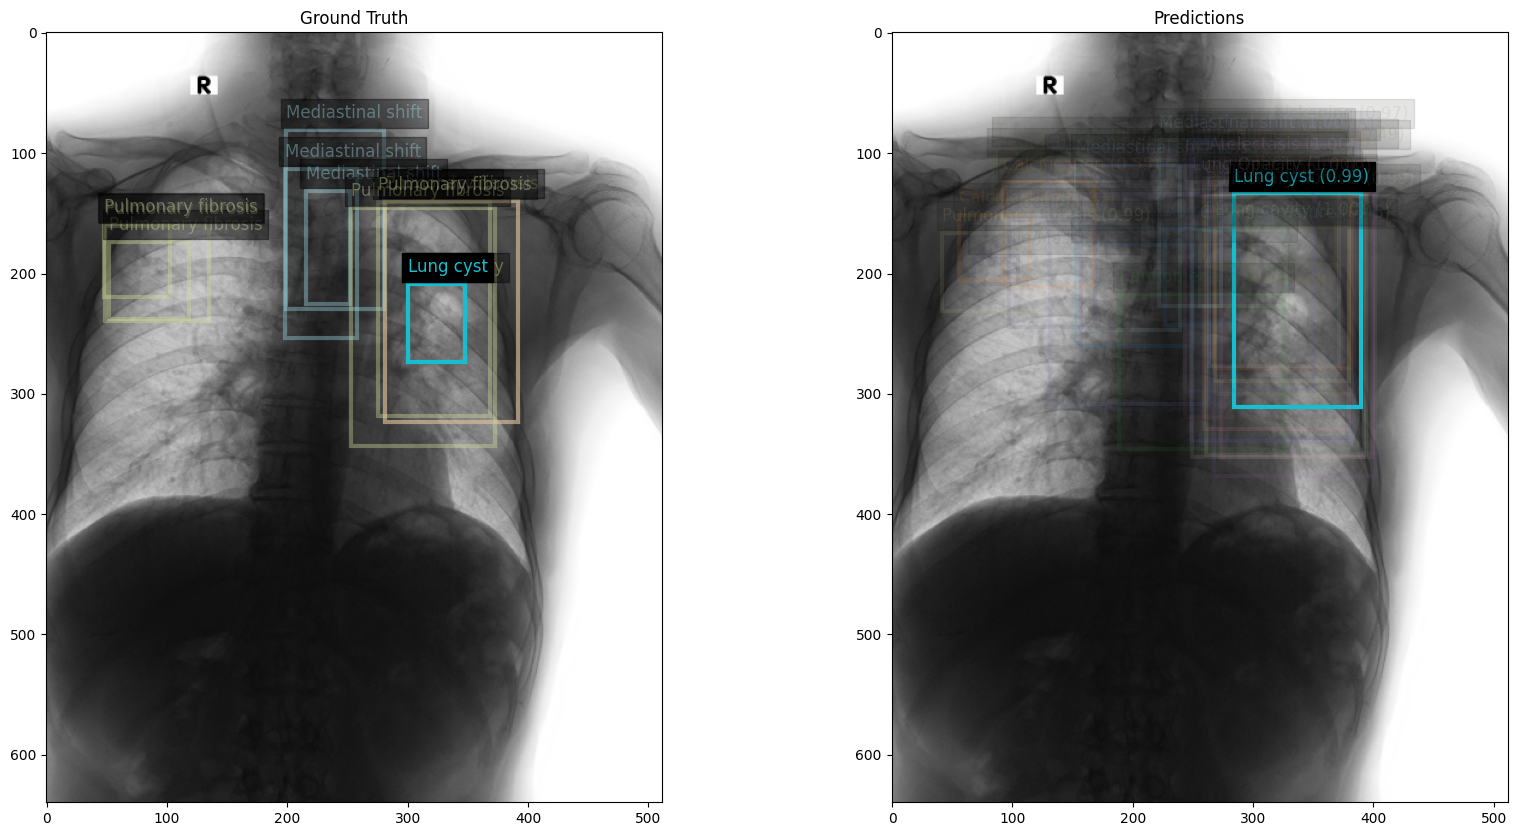

In [209]:
i = 4
i = filtered_idxs[i]
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=VINBIG_BBOX_NAMES,
    figsize=(20, 10),
    format='xyxy',
    classes_to_highlight=[class_name]
)

In [237]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,Adaptive

iou_th=0.1, conf_th=0.3, mAP=0.21285335768481578 (time_input_processing=1.4212632179260254, time_map=1.5613293647766113)
iou_th=0.2, conf_th=0.3, mAP=0.21481562156494832 (time_input_processing=1.4012439250946045, time_map=1.7112152576446533)
iou_th=0.3, conf_th=0.3, mAP=0.2123034239882527 (time_input_processing=1.6750328540802002, time_map=1.8930144309997559)
iou_th=0.4, conf_th=0.3, mAP=0.2114619054365659 (time_input_processing=1.41766357421875, time_map=2.122950315475464)
iou_th=0.5, conf_th=0.3, mAP=0.2059878034520273 (time_input_processing=1.4228854179382324, time_map=2.4600119590759277)
iou_th=0.1, conf_th=0.4, mAP=0.2128858288036254 (time_input_processing=1.3853273391723633, time_map=1.4894113540649414)
iou_th=0.2, conf_th=0.4, mAP=0.21497524083527503 (time_input_processing=1.3860771656036377, time_map=1.6168768405914307)
iou_th=0.3, conf_th=0.4, mAP=0.2126868386322812 (time_input_processing=1.3713436126708984, time_map=1.7768633365631104)
iou_th=0.4, conf_th=0.4, mAP=0.211876901

In [275]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbi

iou_th=0.5, conf_th=0.2, mAP=0.22681358303640178 (time_input_processing=1.4704170227050781, time_map=2.8502895832061768)
iou_th=0.02, conf_th=0.3, mAP=0.22987994495274303 (time_input_processing=1.41888427734375, time_map=1.5441787242889404)
iou_th=0.05, conf_th=0.3, mAP=0.2289466736859538 (time_input_processing=1.419753074645996, time_map=1.5800085067749023)
iou_th=0.1, conf_th=0.3, mAP=0.229847932065386 (time_input_processing=1.4125938415527344, time_map=1.6474854946136475)
iou_th=0.2, conf_th=0.3, mAP=0.2316389208691976 (time_input_processing=1.4143052101135254, time_map=1.8003439903259277)
iou_th=0.3, conf_th=0.3, mAP=0.227953278183278 (time_input_processing=1.4149465560913086, time_map=2.2675180435180664)
iou_th=0.4, conf_th=0.3, mAP=0.2292200226595453 (time_input_processing=1.4164955615997314, time_map=2.2465481758117676)
iou_th=0.5, conf_th=0.3, mAP=0.2257527318926732 (time_input_processing=1.416682243347168, time_map=2.573362350463867)
iou_th=0.02, conf_th=0.4, mAP=0.22863603813

In [13]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20,50),use_classifier_confs).pkl')

mAP@0.0: 0.3796449402749928
mAP@0.02: 0.35388021696659
mAP@0.05: 0.32853463251658116
mAP@0.1: 0.2909711788539044
mAP@0.2: 0.22419969053748165
mAP@0.3: 0.17552839432093365
mAP@0.4: 0.13672884926647164
mAP@0.5: 0.11061779676692725
mAP@0.6: 0.0832069950108797
mAP@0.7: 0.05918209196581829
micro_AP@0.0: 0.4658610496663999
micro_AP@0.02: 0.43306810654885014
micro_AP@0.05: 0.4022612567896444
micro_AP@0.1: 0.35784418601656115
micro_AP@0.2: 0.28316874098771183
micro_AP@0.3: 0.23384504884116025
micro_AP@0.4: 0.18819215278184112
micro_AP@0.5: 0.15329907844198015
micro_AP@0.6: 0.10224245634199547
micro_AP@0.7: 0.05684598243951805
vinbigdata mAP@0.4: 0.16664905665460608
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.19484297075339427
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.15179601107510451
AUPRC(Cardiomegaly): 0.7590300127432235
AUPRC(Pleural thickening): 0.45435088433794035
AUPRC(Aortic enlargement): 0.4188387681046491
AUPRC(Pulmonary fibrosis): 0.6140182516003857
AUPRC(Tuberculosis): 0.73

In [36]:
tmp_test = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20,50),use_classifier_confs).pkl')

In [231]:
tmp = tmp_test
tmp.keys()

dict_keys(['image_paths', 'pred_boxes_list', 'pred_classes_list', 'pred_confs_list', 'classifier_confs', 'gt_bboxes', 'class_ious', 'sample_ious', 'micro_iou', 'macro_iou', 'map_iou_thresholds', 'map_per_class', 'prc_auc', 'best_iou_threshold', 'best_conf_threshold', 'max_det'])

In [232]:
idxs = np.argsort(tmp['sample_ious'])[::-1]

In [233]:
# class_name = 'ILD'
# class_name = 'Pulmonary fibrosis'
# class_name = 'Pneumothorax'
# class_name = 'Lung cyst'
# class_name = 'Pleural effusion'
class_name = 'Consolidation'
# class_idx = VINBIG_BBOX_NAMES.index('Clavicle fracture')
class_idx = VINBIG_BBOX_NAMES.index(class_name)

In [234]:
filtered_idxs = [idx for idx in idxs if len(tmp['gt_bboxes'][idx][class_idx]) > 0]

In [235]:
len(filtered_idxs)

96

0.3145377
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/293df7b3db7c3d58656e9169abffce81.jpg


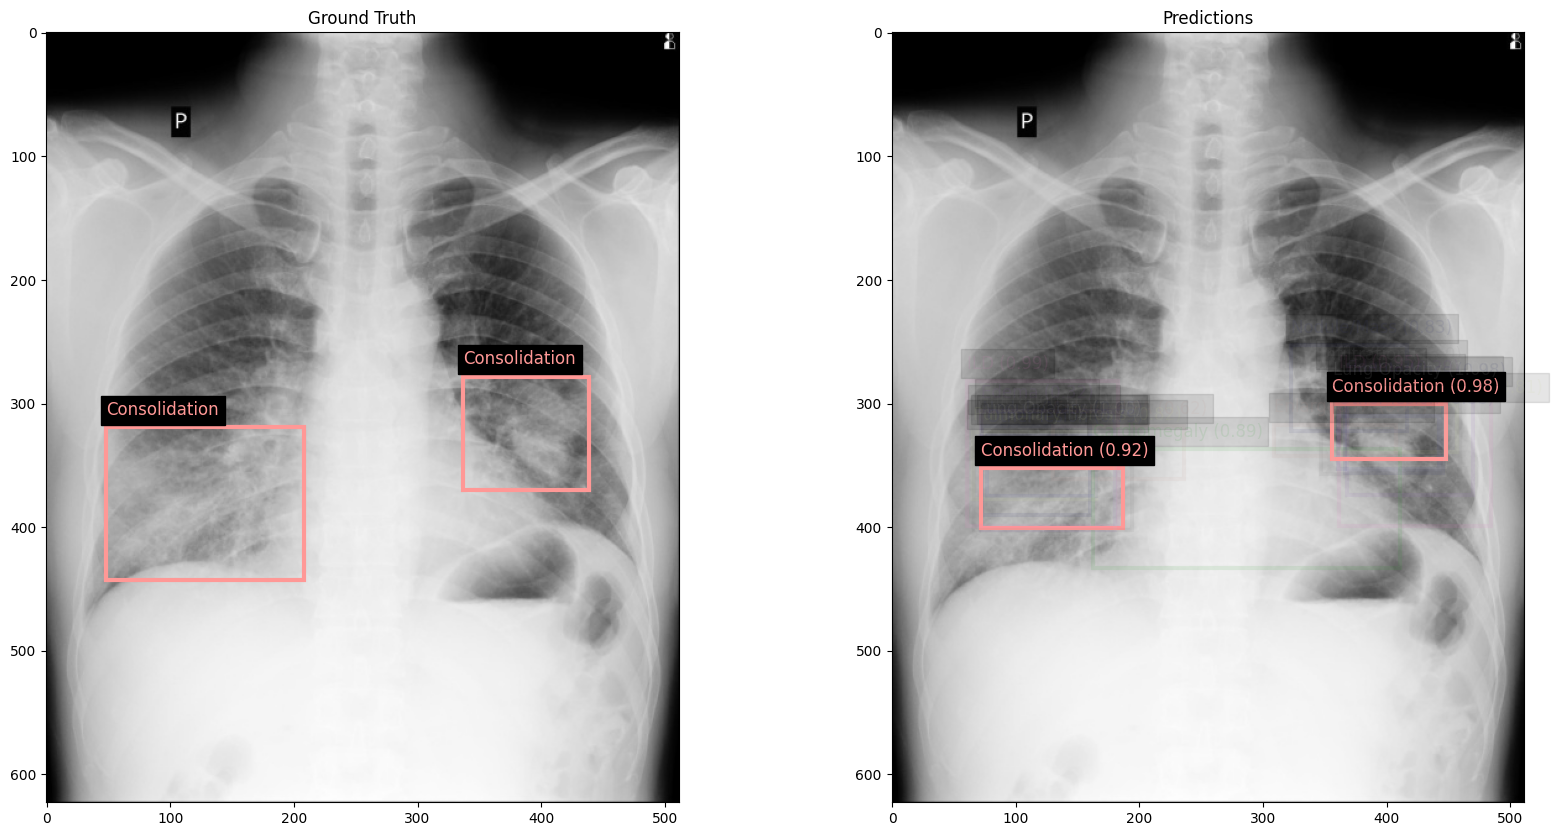

In [246]:
i = -55
i = filtered_idxs[i]
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=VINBIG_BBOX_NAMES,
    figsize=(20, 10),
    format='xyxy',
    classes_to_highlight=[class_name]
)

In [75]:
from medvqa.datasets.vinbig import compute_label_frequencies

In [76]:
label_frequencies = compute_label_frequencies()

In [78]:
vals = tmp['prc_auc']['per_class'][:]
# vals[tmp['prc_auc']['per_class'].index(0.5)] = 0

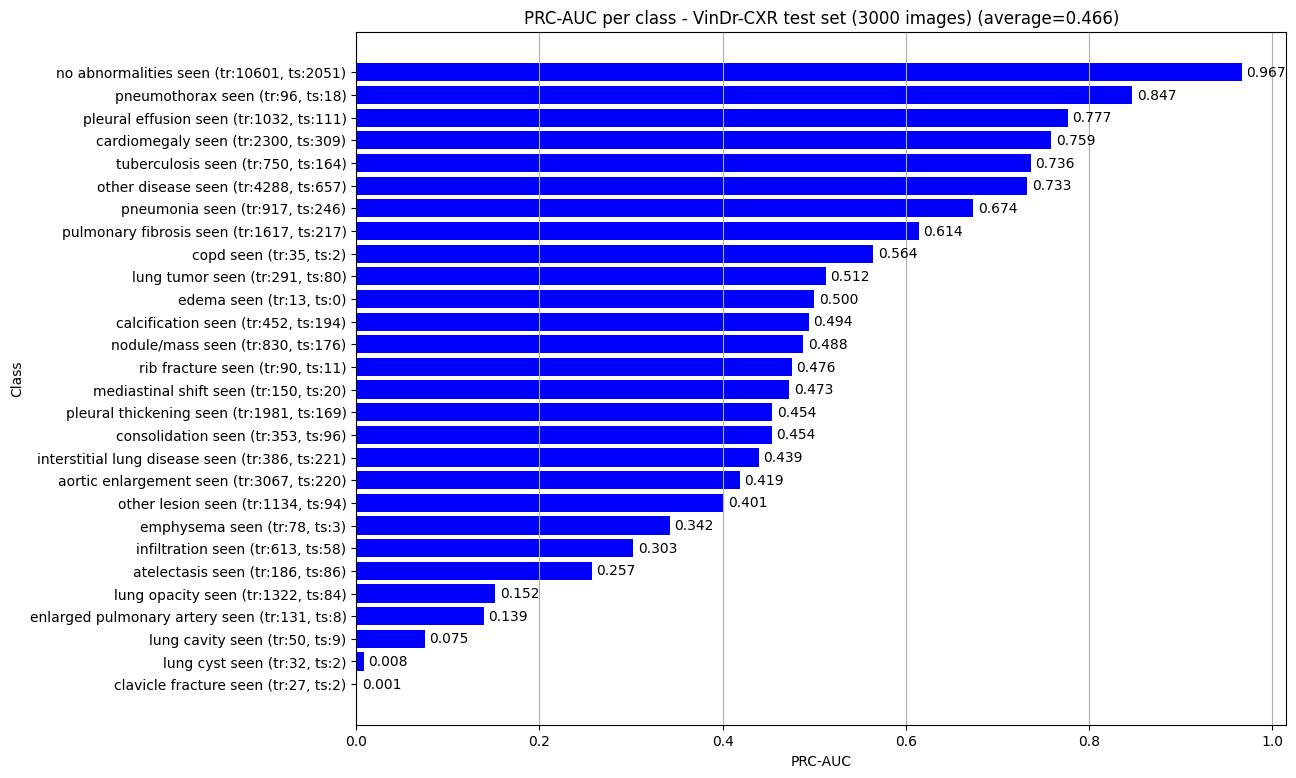

In [79]:
from medvqa.utils.constants import VINBIG_LABELS, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in ALL_VINBIG_CLASSES],
    metric_values=vals,
    title='PRC-AUC per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

In [28]:
tmp['class_ious'].shape

(22,)

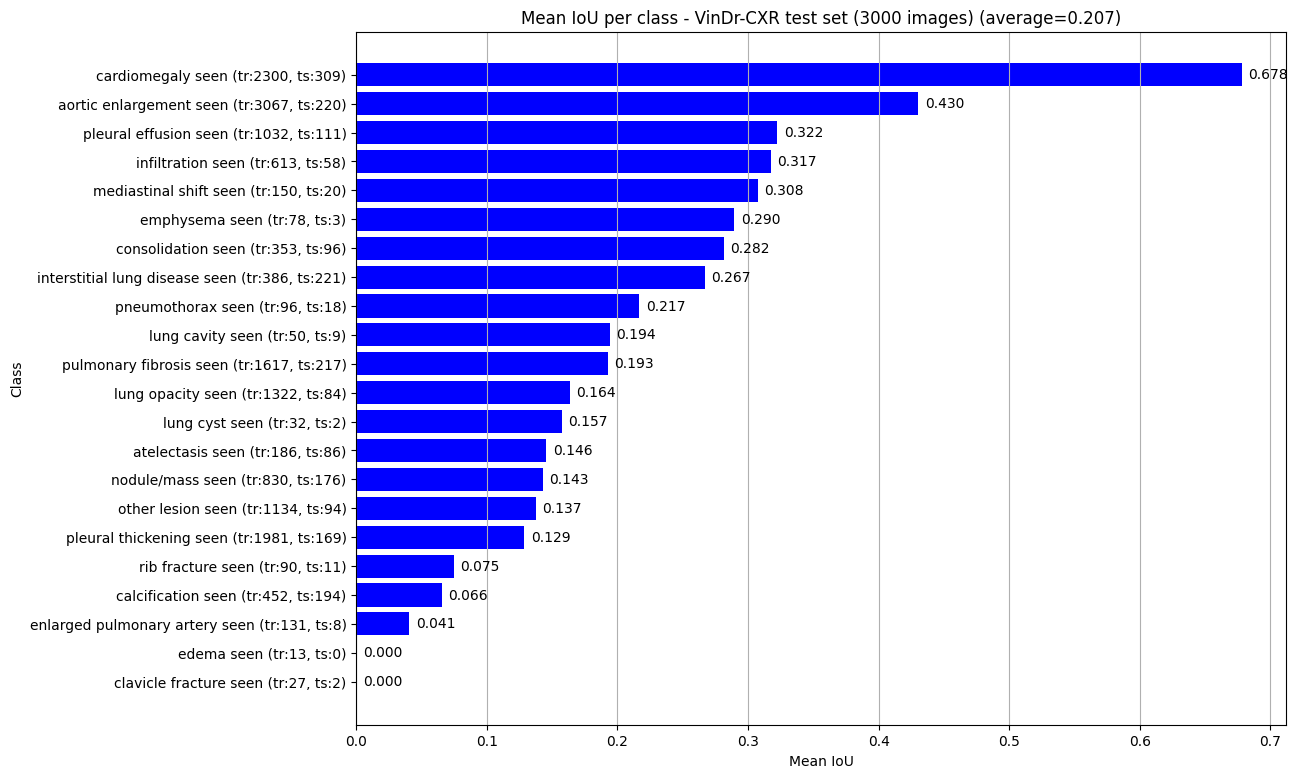

In [29]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_BBOX_NAMES],
    metric_values=tmp['class_ious'],
    title='Mean IoU per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='Mean IoU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

In [32]:
tmp['map_iou_thresholds'],

[0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [31]:
tmp['map_per_class'].shape

(8, 22)

In [33]:
import pandas as pd
metric_names = [f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_BBOX_NAMES]
df = pd.DataFrame(data=tmp['map_per_class'], columns=metric_names)
df

aortic enlargement seen (tr:3067, ts:220)  \
0                                   0.426708   
1                                   0.426708   
2                                   0.420385   
3                                   0.412199   
4                                   0.369258   
5                                   0.308731   
6                                   0.243277   
7                                   0.151277   

   atelectasis seen (tr:186, ts:86)  calcification seen (tr:452, ts:194)  \
0                          0.253015                             0.432987   
1                          0.220471                             0.299126   
2                          0.173476                             0.209879   
3                          0.136276                             0.138592   
4                          0.076906                             0.079588   
5                          0.051169                             0.068057   
6                          0.046766                             0.065082   
7                          0.032809                             0.064074   

   cardiomegaly seen (tr:2300, ts:309)  clavicle fracture seen (tr:27, ts:2)  \
0                             0.761459                              0.000667   
1                             0.761459                              0.000667   
2                             0.761459                              0.000667   
3                             0.761459                              0.000667   
4                             0.761459                              0.000667   
5                             0.761459                              0.000667   
6                             0.750713                              0.000667   
7                             0.704248                              0.000667   

   consolidation seen (tr:353, ts:96)  edema seen (tr:13, ts:0)  \
0                            0.449632                      -0.0   
1                            0.434620                      -0.0   
2                            0.431373                      -0.0   
3                            0.400587                      -0.0   
4                            0.332192                      -0.0   
5                            0.234230                      -0.0   
6                            0.125036                      -0.0   
7                            0.110203                      -0.0   

   emphysema seen (tr:78, ts:3)  \
0                      0.348677   
1                      0.343329   
2                      0.343329   
3                      0.334000   
4                      0.334000   
5                      0.334000   
6                      0.334000   
7                      0.334000   

   enlarged pulmonary artery seen (tr:131, ts:8)  \
0                                       0.135589   
1                                       0.135589   
2                                       0.135589   
3                                       0.127333   
4                                       0.002667   
5                                       0.002667   
6                                       0.002667   
7                                       0.002667   

   interstitial lung disease seen (tr:386, ts:221)  ...  \
0                                         0.424987  ...   
1                                         0.396750  ...   
2                                         0.365699  ...   
3                                         0.340097  ...   
4                                         0.263013  ...   
5                                         0.224609  ...   
6                                         0.175278  ...   
7                                         0.151454  ...   

   lung cavity seen (tr:50, ts:9)  lung cyst seen (tr:32, ts:2)  \
0                        0.090091                      0.018829   
1                        0.090091                      0.006662   
2                        0.090091         

In [47]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

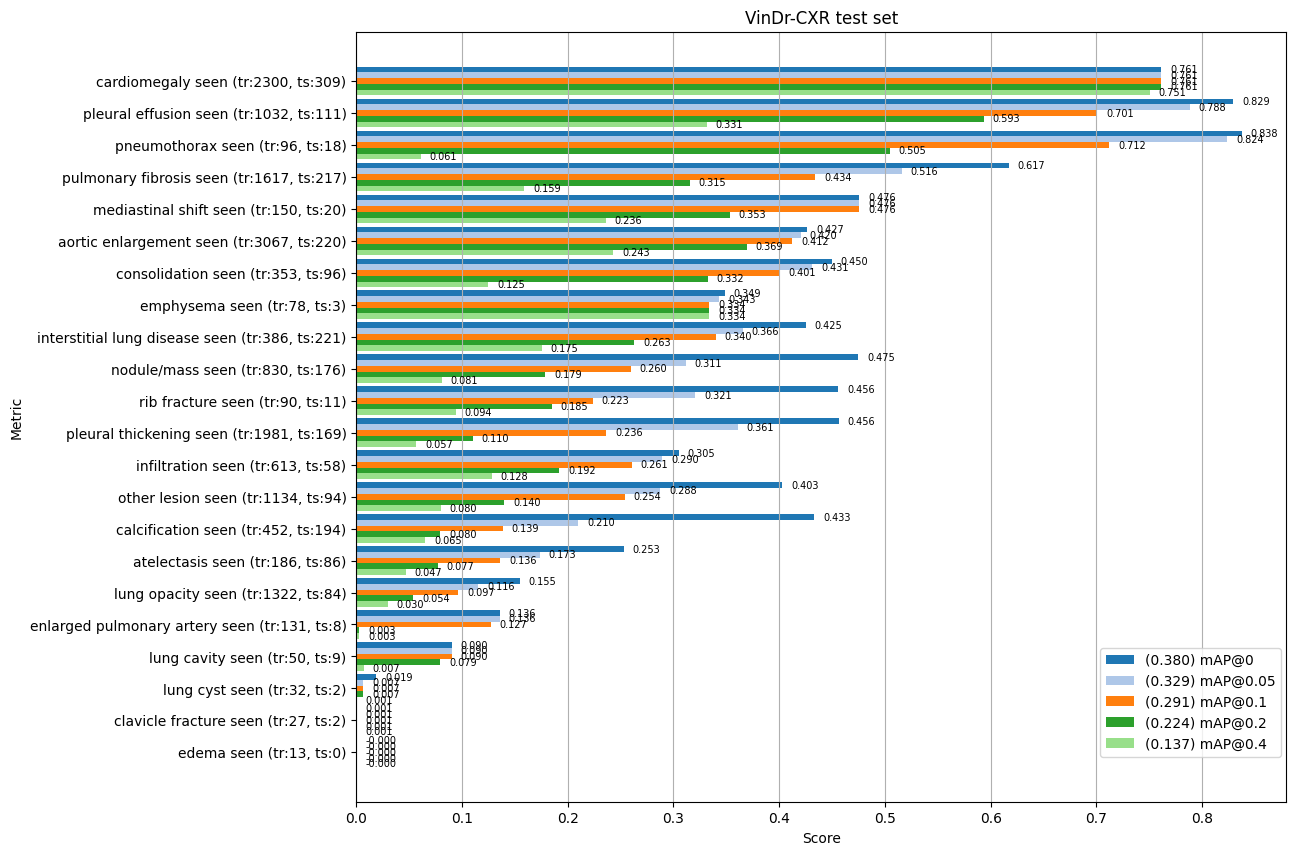

In [57]:
from medvqa.evaluation.plots import plot_metric_bars_per_method

metric_names = [f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_BBOX_NAMES]
dataframe_rows = [df.iloc[0], df.iloc[2], df.iloc[3], df.iloc[4], df.iloc[6]]
method_aliases = ['mAP@0', 'mAP@0.05', 'mAP@0.1', 'mAP@0.2', 'mAP@0.4']
plot_metric_bars_per_method(
    dataframe_rows=dataframe_rows,
    method_aliases=method_aliases,
    metric_names=metric_names,
    metric_aliases=metric_names,
    title='VinDr-CXR test set',
    figsize=(12, 10),
    bbox_to_anchor=(0.8, 0.2)
#     figsize=(8, 15),
#     sort_metrics=True,
#     vertical=True,
)

# 15) microsoft-rad-dino-maira-2+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [163]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
----------------------------------

In [164]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.17359745572300675

In [296]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_Ph

conf_th=0.2, iou_th=0.5, mAP=0.20444610360527998 (time_input_processing=1.527787208557129, time_map=2.295682191848755)
conf_th=0.3, iou_th=0.02, mAP=0.19873570622881653 (time_input_processing=1.482710361480713, time_map=1.3770794868469238)
conf_th=0.3, iou_th=0.05, mAP=0.19874612833324468 (time_input_processing=1.4863665103912354, time_map=1.3912415504455566)
conf_th=0.3, iou_th=0.1, mAP=0.2028823144435261 (time_input_processing=1.4848690032958984, time_map=1.4295685291290283)
conf_th=0.3, iou_th=0.2, mAP=0.2032090049911381 (time_input_processing=1.4875423908233643, time_map=1.5040011405944824)
conf_th=0.3, iou_th=0.3, mAP=0.20368797459195306 (time_input_processing=1.4845149517059326, time_map=1.6272733211517334)
conf_th=0.3, iou_th=0.4, mAP=0.2040680819068552 (time_input_processing=1.4913763999938965, time_map=1.70383620262146)
conf_th=0.3, iou_th=0.5, mAP=0.20344683201734848 (time_input_processing=1.4871220588684082, time_map=1.901602029800415)
conf_th=0.4, iou_th=0.02, mAP=0.1978929

In [60]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.329055921063104
mAP@0.02: 0.2934680900262279
mAP@0.05: 0.27983648576350945
mAP@0.1: 0.26206192546028023
mAP@0.2: 0.21297026070639574
mAP@0.3: 0.17139668053902765
mAP@0.4: 0.13133398093076767
mAP@0.5: 0.10204611726395342
mAP@0.6: 0.07559014987366407
mAP@0.7: 0.05372481732860313
micro_AP@0.0: 0.4176985789680404
micro_AP@0.02: 0.37333281470223856
micro_AP@0.05: 0.3554222370680171
micro_AP@0.1: 0.3286661771894111
micro_AP@0.2: 0.2765185349056811
micro_AP@0.3: 0.22828125420433676
micro_AP@0.4: 0.18294809926074998
micro_AP@0.5: 0.13908558776944763
micro_AP@0.6: 0.09515053876784944
micro_AP@0.7: 0.05546066424957348
vinbigdata mAP@0.4: 0.18209089602870376
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.1927878684530909
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.1387763986241461
AUPRC(Cardiomegaly): 0.7422620104472523
AUPRC(Pleural thickening): 0.38058468457905387
AUPRC(Aortic enlargement): 0.39530940248007357
AUPRC(Pulmonary fibrosis): 0.5790691100832717
AUPRC(Tuberculosis): 0.70

# 16) Phrase Grounding: DN121+CXRFE+FiLM-attention+bbox;VinDR-CXR (average of 10 facts from MIMIC-CXR)

In [13]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241204_083305_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241204_083305_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241204_083305_vinbig_PhraseGrounder(dn121,FiLM_Si

conf_th=0.2, iou_th=0.5, mAP=0.17144770945911333 (time_input_processing=1.8631768226623535, time_map=3.611206293106079)
conf_th=0.3, iou_th=0.02, mAP=0.17881834110194442 (time_input_processing=1.768132209777832, time_map=1.8202636241912842)
conf_th=0.3, iou_th=0.05, mAP=0.1787797967531929 (time_input_processing=1.7714917659759521, time_map=1.8543267250061035)
conf_th=0.3, iou_th=0.1, mAP=0.17905681883995664 (time_input_processing=1.7788341045379639, time_map=1.9646937847137451)
conf_th=0.3, iou_th=0.2, mAP=0.1797091988748127 (time_input_processing=1.7813489437103271, time_map=2.1680331230163574)
conf_th=0.3, iou_th=0.3, mAP=0.178096617327841 (time_input_processing=2.0446574687957764, time_map=2.4624929428100586)
conf_th=0.3, iou_th=0.4, mAP=0.17564473810743952 (time_input_processing=1.7677116394042969, time_map=2.7894840240478516)
conf_th=0.3, iou_th=0.5, mAP=0.1714208377896217 (time_input_processing=1.7791836261749268, time_map=3.3226068019866943)
conf_th=0.4, iou_th=0.02, mAP=0.17855

In [53]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241204_083305_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20),use_classifier_confs).pkl')

mAP@0.0: 0.30184919893961
mAP@0.02: 0.27029352242648885
mAP@0.05: 0.25174131988666626
mAP@0.1: 0.21816650980517086
mAP@0.2: 0.16790555951274694
mAP@0.3: 0.13132314759623126
mAP@0.4: 0.10998802851071106
mAP@0.5: 0.08682491276633163
mAP@0.6: 0.0669134873568472
mAP@0.7: 0.04640124505457976
micro_AP@0.0: 0.42758379368860105
micro_AP@0.02: 0.390071338468723
micro_AP@0.05: 0.3628406287940753
micro_AP@0.1: 0.3211114745358288
micro_AP@0.2: 0.2553909038106014
micro_AP@0.3: 0.20778012382753167
micro_AP@0.4: 0.17340431331077916
micro_AP@0.5: 0.13599603553698095
micro_AP@0.6: 0.10330515926741861
micro_AP@0.7: 0.05981498426689351
vinbigdata mAP@0.4: 0.1577354890536876
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.16746040240592025
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.12988067264296776
AUPRC(Cardiomegaly): 0.7310019507801551
AUPRC(Pleural thickening): 0.4301003455713697
AUPRC(Aortic enlargement): 0.3723402929057807
AUPRC(Pulmonary fibrosis): 0.5378809311248882
AUPRC(Tuberculosis): 0.70453

# 17) Uniformer (no medical pretraining)+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [15]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241203_181237_vinbig_PhraseGrounder(aehrc-uniformer-base-tl-384,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241203_181237_vinbig_PhraseGrounder(aehrc-uniformer-base-tl-384,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241203_181237_vinbig_PhraseGrounder(a

conf_th=0.2, iou_th=0.5, mAP=0.1995700780322795 (time_input_processing=1.5490052700042725, time_map=3.235145330429077)
conf_th=0.3, iou_th=0.02, mAP=0.2009741567077053 (time_input_processing=1.4878277778625488, time_map=1.7991342544555664)
conf_th=0.3, iou_th=0.05, mAP=0.20239593744929377 (time_input_processing=1.4999382495880127, time_map=2.149451971054077)
conf_th=0.3, iou_th=0.1, mAP=0.20264697148247085 (time_input_processing=1.4961998462677002, time_map=1.9307265281677246)
conf_th=0.3, iou_th=0.2, mAP=0.20496418730204066 (time_input_processing=1.500481128692627, time_map=2.120265483856201)
conf_th=0.3, iou_th=0.3, mAP=0.2037158090295172 (time_input_processing=1.4914684295654297, time_map=2.3387022018432617)
conf_th=0.3, iou_th=0.4, mAP=0.2019278580189937 (time_input_processing=1.498408555984497, time_map=2.635566234588623)
conf_th=0.3, iou_th=0.5, mAP=0.1992184203706774 (time_input_processing=1.500654697418213, time_map=2.9801690578460693)
conf_th=0.4, iou_th=0.02, mAP=0.1998116083

In [59]:
compute_map_metrics_from_results(results_path='/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241203_181237_vinbig_PhraseGrounder(aehrc-uniformer-base-tl-384,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20),use_classifier_confs).pkl')

mAP@0.0: 0.33427463858289275
mAP@0.02: 0.30748262914487695
mAP@0.05: 0.2846896430410389
mAP@0.1: 0.25256971865050765
mAP@0.2: 0.19504484754717238
mAP@0.3: 0.15807562371908548
mAP@0.4: 0.12905255925339046
mAP@0.5: 0.08628566442380507
mAP@0.6: 0.06468959249159088
mAP@0.7: 0.045244907059133505
micro_AP@0.0: 0.4467809216759334
micro_AP@0.02: 0.40873508337299536
micro_AP@0.05: 0.38307984068226614
micro_AP@0.1: 0.34326494238995964
micro_AP@0.2: 0.27872307435358434
micro_AP@0.3: 0.22540698515748997
micro_AP@0.4: 0.1866718645354045
micro_AP@0.5: 0.14392480981680023
micro_AP@0.6: 0.10172437145400513
micro_AP@0.7: 0.05791511669221186
vinbigdata mAP@0.4: 0.16535190998329136
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.17759012076321024
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.13009578054743692
AUPRC(Cardiomegaly): 0.7267444694787923
AUPRC(Pleural thickening): 0.42297843257093226
AUPRC(Aortic enlargement): 0.3710706742716918
AUPRC(Pulmonary fibrosis): 0.5541597376455458
AUPRC(Tuberculosis)

# 18) YOLOv11 (fact-conditioned)+CXRFE; VinDR-CXR

In [8]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)" \
--num_workers 3 \
--max_images_per_batch 30 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--use_classifier_confs_for_map \
--use_amp \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)
   max_images_per_batch: 30
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)/

PRC-AUC(aortic enlargement seen): 0.3306503772491289
PRC-AUC(atelectasis seen): 0.2123225470725567
PRC-AUC(calcification seen): 0.21966594357670477
PRC-AUC(cardiomegaly seen): 0.5659581284538102
PRC-AUC(clavicle fracture seen): 0.0018250865485576206
PRC-AUC(consolidation seen): 0.12608519486716996
PRC-AUC(edema seen): 0.5
PRC-AUC(emphysema seen): 0.08579155891886904
PRC-AUC(enlarged pulmonary artery seen): 0.009573641107687166
PRC-AUC(interstitial lung disease seen): 0.17090381103593336
PRC-AUC(infiltration seen): 0.08575381399741286
PRC-AUC(lung opacity seen): 0.09436710117732887
PRC-AUC(lung cavity seen): 0.018521779451116577
PRC-AUC(lung cyst seen): 0.0028162404856420836
PRC-AUC(mediastinal shift seen): 0.08692890147538868
PRC-AUC(nodule/mass seen): 0.12012928115984778
PRC-AUC(other lesion seen): 0.12369321531487544
PRC-AUC(pleural effusion seen): 0.3339684485695988
PRC-AUC(pleural thickening seen): 0.18971820538345827
PRC-AUC(pneumothorax seen): 0.058319640455246465
PRC-AUC(pulmona

In [13]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)" \
--num_workers 3 \
--max_images_per_batch 30 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--use_amp \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)
   max_images_per_batch: 30
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(

mAP@0.0: 0.13795253049789685
mAP@0.02: 0.1273266703309421
mAP@0.05: 0.1252449708734816
mAP@0.1: 0.12245144999769376
mAP@0.2: 0.1119747085999188
mAP@0.3: 0.09671627237459252
mAP@0.4: 0.08588667705891273
mAP@0.5: 0.07200292600245647
micro_AP@0.0: 0.19630794015336836
micro_AP@0.02: 0.1840329210964883
micro_AP@0.05: 0.18062603335851968
micro_AP@0.1: 0.1769527213818029
micro_AP@0.2: 0.16430368038760657
micro_AP@0.3: 0.14810825952394546
micro_AP@0.4: 0.1343172005939315
micro_AP@0.5: 0.11775813104116722
Saving metrics to file ...
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.10),use_classifier_confs).pkl


In [62]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.13795253049789685
mAP@0.02: 0.1273266703309421
mAP@0.05: 0.1252449708734816
mAP@0.1: 0.12245144999769376
mAP@0.2: 0.1119747085999188
mAP@0.3: 0.09671627237459252
mAP@0.4: 0.08588667705891273
mAP@0.5: 0.07200292600245647
mAP@0.6: 0.05976586912561606
mAP@0.7: 0.047417183326962584
micro_AP@0.0: 0.19630794015336836
micro_AP@0.02: 0.1840329210964883
micro_AP@0.05: 0.18062603335851968
micro_AP@0.1: 0.1769527213818029
micro_AP@0.2: 0.16430368038760657
micro_AP@0.3: 0.14810825952394546
micro_AP@0.4: 0.1343172005939315
micro_AP@0.5: 0.11775813104116722
micro_AP@0.6: 0.09425190401025997
micro_AP@0.7: 0.062034279151396914
vinbigdata mAP@0.4: 0.11715426236241842
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.11835277549052277
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.09273790940830276
AUPRC(Cardiomegaly): 0.5632673372932886
AUPRC(Pleural thickening): 0.18846844975923543
AUPRC(Aortic enlargement): 0.32951522890615437
AUPRC(Pulmonary fibrosis): 0.19909092586498003
AUPRC(Tuberculosis)

# 19) YOLOv11 (feature extraction)+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [3]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241211_162359_vinbig_PhraseGrounder(YOLOv11FeatureExtractor(yolo11l),AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 30 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--use_amp \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241211_162359_vinbig_PhraseGrounder(YOLOv11FeatureExtractor(yolo11l),AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 30
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241211_162359_vinbig_Ph

mAP(micro_avg): 0.3592350824790221
mAP(macro_avg): 0.17552832116446698
Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 22)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.02, mAP=0.06258767388218306 (time_input_processing=2.132866859436035, time_map=3.40722393989563)
conf_th=0.1, iou_th=0.05, mAP=0.06365540950375281 (time_input_processing=2.057518243789673, time_map=3.9529876708984375)
conf_th=0.1, iou_th=0.1, mAP=0.0635851054262785 (time_input_processing=2.041339159011841, time_map=4.066857814788818)
conf_th=0.1, iou_th=0.2, mAP=0.0639227257296837 (time_input_processing=2.0817272663116455, time_map=4.986088752746582)
conf_th=0.1, iou_th=0.3, mAP=0.06338010721364747 (time_input_processing=2.3511478900909424, time_map=6.0928614139556885)
conf_th=0.1, iou_th=0.4, mAP=0.06454312611000236 (time_input_processing=2.1027402877807617, time_map=7.385729551315308)
conf_th=0.1, iou_th=0.5, mAP=0.06530488457463096 (time_input_processing=2.389275074005

Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241211_162359_vinbig_PhraseGrounder(YOLOv11FeatureExtractor(yolo11l),AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.20),use_classifier_confs).pkl


In [61]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241211_162359_vinbig_PhraseGrounder(YOLOv11FeatureExtractor(yolo11l),AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.20),use_classifier_confs).pkl')

mAP@0.0: 0.12337821683332754
mAP@0.02: 0.10006981981471785
mAP@0.05: 0.08568271932957994
mAP@0.1: 0.06991384243844072
mAP@0.2: 0.0590510343969602
mAP@0.3: 0.052725088210361176
mAP@0.4: 0.04551320934215677
mAP@0.5: 0.039934356407050696
mAP@0.6: 0.03750126392431316
mAP@0.7: 0.03599196511152424
micro_AP@0.0: 0.1662926658216978
micro_AP@0.02: 0.14206788702464102
micro_AP@0.05: 0.12612695872032537
micro_AP@0.1: 0.11217428781593679
micro_AP@0.2: 0.09421166669278588
micro_AP@0.3: 0.07520013300625437
micro_AP@0.4: 0.05511854051463802
micro_AP@0.5: 0.040305584800760144
micro_AP@0.6: 0.034360438015917864
micro_AP@0.7: 0.03224903261544243
vinbigdata mAP@0.4: 0.06429631417671279
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.06484858280689702
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.10127611587885131
AUPRC(Cardiomegaly): 0.42129049217243664
AUPRC(Pleural thickening): 0.16406548084360434
AUPRC(Aortic enlargement): 0.26237210818871404
AUPRC(Pulmonary fibrosis): 0.1891894150066163
AUPRC(Tubercu

# 20) MedSAM(feature extraction)+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [5]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241220_102157_vinbig_PhraseGrounder(wanglab-medsam-vit-base,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 8 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--use_amp \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241220_102157_vinbig_PhraseGrounder(wanglab-medsam-vit-base,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 8
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241220_102157_vinbig_PhraseGround

conf_th=0.2, iou_th=0.2, mAP=0.11955899603118803 (time_input_processing=2.045609474182129, time_map=2.132370948791504)
conf_th=0.2, iou_th=0.3, mAP=0.11888254218971386 (time_input_processing=2.0453741550445557, time_map=2.2363204956054688)
conf_th=0.2, iou_th=0.4, mAP=0.11951237420832696 (time_input_processing=2.0491809844970703, time_map=2.6562306880950928)
conf_th=0.2, iou_th=0.5, mAP=0.1200319371786199 (time_input_processing=2.049748659133911, time_map=2.592710256576538)
conf_th=0.3, iou_th=0.02, mAP=0.11849187623154167 (time_input_processing=2.039421319961548, time_map=1.9146349430084229)
conf_th=0.3, iou_th=0.05, mAP=0.11863842071496725 (time_input_processing=2.0351855754852295, time_map=1.9187970161437988)
conf_th=0.3, iou_th=0.1, mAP=0.11898237948599893 (time_input_processing=2.0268421173095703, time_map=2.2440407276153564)
conf_th=0.3, iou_th=0.2, mAP=0.11946465720342844 (time_input_processing=2.0552594661712646, time_map=2.0216071605682373)
conf_th=0.3, iou_th=0.3, mAP=0.11878

In [63]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241220_102157_vinbig_PhraseGrounder(wanglab-medsam-vit-base,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.2166070889551959
mAP@0.02: 0.17046794972278495
mAP@0.05: 0.16184255334787984
mAP@0.1: 0.14554746976523408
mAP@0.2: 0.11876149532600139
mAP@0.3: 0.10017434551677783
mAP@0.4: 0.07830575695497505
mAP@0.5: 0.06197295046478762
mAP@0.6: 0.04850085057227124
mAP@0.7: 0.03861596036291327
micro_AP@0.0: 0.30958405826354296
micro_AP@0.02: 0.24311746926118402
micro_AP@0.05: 0.2326086289626001
micro_AP@0.1: 0.21016492207833012
micro_AP@0.2: 0.17962781385751186
micro_AP@0.3: 0.1529026789651921
micro_AP@0.4: 0.12576187595902552
micro_AP@0.5: 0.09704604786016166
micro_AP@0.6: 0.06558063254660985
micro_AP@0.7: 0.04084089601372439
vinbigdata mAP@0.4: 0.11985332015807848
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.12200688460906517
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.09495989974569577
AUPRC(Cardiomegaly): 0.6890015147930043
AUPRC(Pleural thickening): 0.2864912488181195
AUPRC(Aortic enlargement): 0.326383930470059
AUPRC(Pulmonary fibrosis): 0.41745316677378963
AUPRC(Tuberculosis): 

# 21) cxrmate-rrg24-Uniformer+CXRFE+FiLM+SigmoidAtt; MIMIC-CXR (pos-neg-facts) -> VinDr-CXR (fine-tuning)

In [5]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250109_202152_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250109_202152_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250109_202152_vinbig_Phr

conf_th=0.2, iou_th=0.3, mAP=0.22596122542774985 (time_input_processing=1.4468815326690674, time_map=2.027540683746338)
conf_th=0.2, iou_th=0.4, mAP=0.2259605824830194 (time_input_processing=1.7245948314666748, time_map=2.2796430587768555)
conf_th=0.2, iou_th=0.5, mAP=0.2286848965196352 (time_input_processing=1.4598174095153809, time_map=2.597694158554077)
conf_th=0.3, iou_th=0.02, mAP=0.23276229730749243 (time_input_processing=1.4165005683898926, time_map=1.4671332836151123)
conf_th=0.3, iou_th=0.05, mAP=0.23131464170667188 (time_input_processing=1.3979134559631348, time_map=1.4941990375518799)
conf_th=0.3, iou_th=0.1, mAP=0.22989115495355358 (time_input_processing=1.413444995880127, time_map=1.563356637954712)
conf_th=0.3, iou_th=0.2, mAP=0.22616435957530567 (time_input_processing=1.4143400192260742, time_map=1.7082717418670654)
conf_th=0.3, iou_th=0.3, mAP=0.22416426785124 (time_input_processing=1.4179229736328125, time_map=1.8795912265777588)
conf_th=0.3, iou_th=0.4, mAP=0.22817367

In [8]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250109_202152_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.05,0.40),use_classifier_confs).pkl')

mAP@0.0: 0.3674999871956434
mAP@0.02: 0.33904432761592573
mAP@0.05: 0.32093668668168673
mAP@0.1: 0.28910925096710505
mAP@0.2: 0.21672626059135622
mAP@0.3: 0.1809636046303811
mAP@0.4: 0.1449051980143942
mAP@0.5: 0.11815300421376927
mAP@0.6: 0.08514364589791573
mAP@0.7: 0.05865425046403816
micro_AP@0.0: 0.44024138620316866
micro_AP@0.02: 0.3992367461819203
micro_AP@0.05: 0.3772560396379781
micro_AP@0.1: 0.3433485508196693
micro_AP@0.2: 0.2713073521434263
micro_AP@0.3: 0.22425586473176196
micro_AP@0.4: 0.18541337063004157
micro_AP@0.5: 0.14547229615985469
micro_AP@0.6: 0.09135001528471527
micro_AP@0.7: 0.05042766833390393
vinbigdata mAP@0.4: 0.18031980270568243
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.19614260089173516
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.146326432579686
AUPRC(Cardiomegaly): 0.7624293229570219
AUPRC(Pleural thickening): 0.46647987940984426
AUPRC(Aortic enlargement): 0.4423907928177565
AUPRC(Pulmonary fibrosis): 0.6091896529177745
AUPRC(Tuberculosis): 0.700

# 22) cxrmate-rrg24-Uniformer+CXRFE+FiLM+SigmoidAtt; MIMIC-CXR (pos-neg-facts) + VinDR-CXR

In [6]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250108_070909_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250108_070909_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250108_070909_

conf_th=0.2, iou_th=0.3, mAP=0.20716842304054375 (time_input_processing=1.392418384552002, time_map=2.72263765335083)
conf_th=0.2, iou_th=0.4, mAP=0.20474092741706018 (time_input_processing=1.3922111988067627, time_map=2.69954252243042)
conf_th=0.2, iou_th=0.5, mAP=0.21296510402076477 (time_input_processing=1.3984789848327637, time_map=2.997565746307373)
conf_th=0.3, iou_th=0.02, mAP=0.2005822462484246 (time_input_processing=1.3548905849456787, time_map=1.7653183937072754)
conf_th=0.3, iou_th=0.05, mAP=0.20087572895054773 (time_input_processing=1.3484740257263184, time_map=1.8049120903015137)
conf_th=0.3, iou_th=0.1, mAP=0.20241440699086397 (time_input_processing=1.3488483428955078, time_map=1.8703722953796387)
conf_th=0.3, iou_th=0.2, mAP=0.20024348622332797 (time_input_processing=1.3462128639221191, time_map=2.014167547225952)
conf_th=0.3, iou_th=0.3, mAP=0.20223441979595377 (time_input_processing=1.3490769863128662, time_map=2.183905839920044)
conf_th=0.3, iou_th=0.4, mAP=0.19982897

In [9]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250108_070909_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.3826115277198518
mAP@0.02: 0.34445001431794353
mAP@0.05: 0.3141781820433426
mAP@0.1: 0.2570045662129949
mAP@0.2: 0.19235697437905797
mAP@0.3: 0.1509006851612962
mAP@0.4: 0.11390788040017846
mAP@0.5: 0.08618716197729054
mAP@0.6: 0.06356311563315616
mAP@0.7: 0.04364016945584856
micro_AP@0.0: 0.46803984446807767
micro_AP@0.02: 0.4209122567017086
micro_AP@0.05: 0.3902849553552422
micro_AP@0.1: 0.33684208725911324
micro_AP@0.2: 0.2658636451079464
micro_AP@0.3: 0.2156239689070335
micro_AP@0.4: 0.17103830846212048
micro_AP@0.5: 0.12667461636264316
micro_AP@0.6: 0.07891732852667721
micro_AP@0.7: 0.04657712506150556
vinbigdata mAP@0.4: 0.152287858503588
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.17544509388953072
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.13706511651394399
AUPRC(Cardiomegaly): 0.7814492615761424
AUPRC(Pleural thickening): 0.47618357635218783
AUPRC(Aortic enlargement): 0.4195154388476408
AUPRC(Pulmonary fibrosis): 0.5796883881343259
AUPRC(Tuberculosis): 0.7195

# 23) cxrmate-rrg24-Uniformer+CXRFE+FiLM+SigmoidAtt; MIMIC-CXR (pos-neg-facts) + VinDR-CXR -> VinDR-CXR only (fine-tuning)

In [7]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250109_202438_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250109_202438_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250109_202438_vinbig_Phr

conf_th=0.2, iou_th=0.3, mAP=0.22932321498797545 (time_input_processing=1.4726030826568604, time_map=2.2266361713409424)
conf_th=0.2, iou_th=0.4, mAP=0.22705395896212208 (time_input_processing=1.4790191650390625, time_map=2.4812893867492676)
conf_th=0.2, iou_th=0.5, mAP=0.2231086551044509 (time_input_processing=1.480207920074463, time_map=2.8161661624908447)
conf_th=0.3, iou_th=0.02, mAP=0.22447389073765478 (time_input_processing=1.4304683208465576, time_map=1.5617289543151855)
conf_th=0.3, iou_th=0.05, mAP=0.2267298441578853 (time_input_processing=1.4285871982574463, time_map=1.6055333614349365)
conf_th=0.3, iou_th=0.1, mAP=0.22561289716616892 (time_input_processing=1.426347017288208, time_map=1.6726007461547852)
conf_th=0.3, iou_th=0.2, mAP=0.2235167824513364 (time_input_processing=1.429450511932373, time_map=1.8340842723846436)
conf_th=0.3, iou_th=0.3, mAP=0.22646684865494918 (time_input_processing=1.4302175045013428, time_map=2.299441337585449)
conf_th=0.3, iou_th=0.4, mAP=0.223973

In [10]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250109_202438_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.30,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.3741408168831395
mAP@0.02: 0.3486114996267247
mAP@0.05: 0.323703002751862
mAP@0.1: 0.27876882556351507
mAP@0.2: 0.20201073852888418
mAP@0.3: 0.15814151755446235
mAP@0.4: 0.13551808286223324
mAP@0.5: 0.1023150898319661
mAP@0.6: 0.0689751182245955
mAP@0.7: 0.051980916909695536
micro_AP@0.0: 0.4761851793081614
micro_AP@0.02: 0.4428476239194854
micro_AP@0.05: 0.4047683579251928
micro_AP@0.1: 0.35631662981968915
micro_AP@0.2: 0.27868719346342735
micro_AP@0.3: 0.2255793985661316
micro_AP@0.4: 0.19500787103254882
micro_AP@0.5: 0.14879360336079533
micro_AP@0.6: 0.08934746978247196
micro_AP@0.7: 0.056826084720883
vinbigdata mAP@0.4: 0.18232271807483533
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.19158985459949773
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.14144045132102345
AUPRC(Cardiomegaly): 0.7732010522140431
AUPRC(Pleural thickening): 0.48614535689493316
AUPRC(Aortic enlargement): 0.43863401914741007
AUPRC(Pulmonary fibrosis): 0.5820945218242843
AUPRC(Tuberculosis): 0.7207

# 24) Rad-DINO+CXRFE+FiLM+SigmoidAtt; VinDr-CXR

In [4]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250123_200626_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 25 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250123_200626_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 25
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250123_200626_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256

mAP@0.0: 0.2880436127494017
mAP@0.02: 0.2508617412059024
mAP@0.05: 0.23506300080027212
mAP@0.1: 0.206431737263072
mAP@0.2: 0.16826886934421084
mAP@0.3: 0.13293304956103993
mAP@0.4: 0.10161552185893785
mAP@0.5: 0.07784087930543374
mAP@0.6: 0.0587845440043832
mAP@0.7: 0.03940172873796192
micro_AP@0.0: 0.3613887511782855
micro_AP@0.02: 0.31522408051081974
micro_AP@0.05: 0.2958847208973333
micro_AP@0.1: 0.2727316766135866
micro_AP@0.2: 0.22957122313779535
micro_AP@0.3: 0.1850530986096338
micro_AP@0.4: 0.15111522910067512
micro_AP@0.5: 0.11256349990014355
micro_AP@0.6: 0.07752869095131681
micro_AP@0.7: 0.04325754108675099
Saving metrics to file ...
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250123_200626_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl


In [5]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250123_200626_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 25 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250123_200626_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 25
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250123_200626_vinbig_PhraseGrounder(

conf_th=0.2, iou_th=0.3, mAP=0.17632514210573957 (time_input_processing=1.663482427597046, time_map=2.3251142501831055)
conf_th=0.2, iou_th=0.4, mAP=0.17567446739693893 (time_input_processing=1.6561291217803955, time_map=2.641145706176758)
conf_th=0.2, iou_th=0.5, mAP=0.17616859571599497 (time_input_processing=1.650118350982666, time_map=3.086951971054077)
conf_th=0.3, iou_th=0.02, mAP=0.17304715300952733 (time_input_processing=1.6083600521087646, time_map=2.0813164710998535)
conf_th=0.3, iou_th=0.05, mAP=0.17305530530821533 (time_input_processing=1.607496738433838, time_map=1.7882168292999268)
conf_th=0.3, iou_th=0.1, mAP=0.17333470990085653 (time_input_processing=1.6072173118591309, time_map=1.859032154083252)
conf_th=0.3, iou_th=0.2, mAP=0.17446148803095618 (time_input_processing=1.6188030242919922, time_map=2.0522964000701904)
conf_th=0.3, iou_th=0.3, mAP=0.17611374752899137 (time_input_processing=1.6203696727752686, time_map=2.1946582794189453)
conf_th=0.3, iou_th=0.4, mAP=0.17550

In [8]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250123_200626_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.30,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.29845943644295964
mAP@0.02: 0.26614315865676763
mAP@0.05: 0.2514577184285049
mAP@0.1: 0.22105607880933809
mAP@0.2: 0.17185425581711608
mAP@0.3: 0.13745370522792782
mAP@0.4: 0.10180089137996856
mAP@0.5: 0.08230345388546448
mAP@0.6: 0.06129930205258539
mAP@0.7: 0.0408556247026935
micro_AP@0.0: 0.41558919588805227
micro_AP@0.02: 0.37068513013923526
micro_AP@0.05: 0.34915781566378584
micro_AP@0.1: 0.3177194755132385
micro_AP@0.2: 0.2604725541973474
micro_AP@0.3: 0.20977541740655714
micro_AP@0.4: 0.16734229973924028
micro_AP@0.5: 0.1290079467575503
micro_AP@0.6: 0.08865927498350733
micro_AP@0.7: 0.046155115040525926
vinbigdata mAP@0.4: 0.14740950956644264
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.1668793831212596
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.15635063721299503
AUPRC(Cardiomegaly): 0.730919630350294
AUPRC(Pleural thickening): 0.3933284337516296
AUPRC(Aortic enlargement): 0.42220953546200873
AUPRC(Pulmonary fibrosis): 0.5573012977787991
AUPRC(Tuberculosis): 0.

# 25) cxrmate-rrg24-Uniformer+CXRFE+FiLM+SigmoidAtt; MIMIC-CXR (pos-neg-facts v2.0) (0.9) + VinDr-CXR (0.1)

In [9]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250125_133402_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250125_133402_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250125_133402_

conf_th=0.2, iou_th=0.4, mAP=0.18730800783255858 (time_input_processing=1.6038203239440918, time_map=3.3814733028411865)
conf_th=0.2, iou_th=0.5, mAP=0.1852451519669768 (time_input_processing=1.8895478248596191, time_map=3.862539291381836)
conf_th=0.3, iou_th=0.02, mAP=0.1746906587487052 (time_input_processing=1.5283801555633545, time_map=2.002626657485962)
conf_th=0.3, iou_th=0.05, mAP=0.17501036655750457 (time_input_processing=1.5363349914550781, time_map=2.0721724033355713)
conf_th=0.3, iou_th=0.1, mAP=0.1749719238737391 (time_input_processing=1.539341926574707, time_map=2.1807940006256104)
conf_th=0.3, iou_th=0.2, mAP=0.1796776230794668 (time_input_processing=1.5321815013885498, time_map=2.487157106399536)
conf_th=0.3, iou_th=0.3, mAP=0.18519374411291636 (time_input_processing=1.5336575508117676, time_map=2.716233253479004)
conf_th=0.3, iou_th=0.4, mAP=0.18644437068094188 (time_input_processing=1.5771703720092773, time_map=3.356285572052002)
conf_th=0.3, iou_th=0.5, mAP=0.184835240

In [12]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250125_133402_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.3778402611146893
mAP@0.02: 0.32093774244982076
mAP@0.05: 0.2821160927740261
mAP@0.1: 0.23349726806368787
mAP@0.2: 0.1587334879511462
mAP@0.3: 0.11784385670572944
mAP@0.4: 0.0942078391390123
mAP@0.5: 0.06492586730713414
mAP@0.6: 0.0391008961406909
mAP@0.7: 0.03382884111109719
micro_AP@0.0: 0.4585928011715772
micro_AP@0.02: 0.4002574898708934
micro_AP@0.05: 0.35604797867815025
micro_AP@0.1: 0.30792431110124185
micro_AP@0.2: 0.2281698587314428
micro_AP@0.3: 0.17757420616633318
micro_AP@0.4: 0.13552448162425346
micro_AP@0.5: 0.07665777178006443
micro_AP@0.6: 0.04499282248299488
micro_AP@0.7: 0.03433922111664149
vinbigdata mAP@0.4: 0.12665902291431183
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.144863127565672
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.15314853938309655
AUPRC(Cardiomegaly): 0.7825322655137228
AUPRC(Pleural thickening): 0.48106944709682387
AUPRC(Aortic enlargement): 0.4674731953966747
AUPRC(Pulmonary fibrosis): 0.5716261744724436
AUPRC(Tuberculosis): 0.7483

# 26) cxrmate-rrg24-Uniformer+CXRFE+FiLM+SigmoidAtt; MIMIC-CXR (pos-neg-facts v2.0) (0.9) + VinDr-CXR (0.1) -> VinDr-CXR

In [10]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250126_205820_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250126_205820_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250126_205820_vinbig_Phr

conf_th=0.2, iou_th=0.3, mAP=0.22492405751656525 (time_input_processing=1.5066208839416504, time_map=2.5099124908447266)
conf_th=0.2, iou_th=0.4, mAP=0.2222563731592996 (time_input_processing=1.5302000045776367, time_map=2.8328030109405518)
conf_th=0.2, iou_th=0.5, mAP=0.22035711616909834 (time_input_processing=1.5320305824279785, time_map=3.20908260345459)
conf_th=0.3, iou_th=0.02, mAP=0.21953933892792962 (time_input_processing=1.4862899780273438, time_map=1.7524077892303467)
conf_th=0.3, iou_th=0.05, mAP=0.22050300517335278 (time_input_processing=1.4750866889953613, time_map=2.0930426120758057)
conf_th=0.3, iou_th=0.1, mAP=0.22044866300878885 (time_input_processing=1.4777395725250244, time_map=1.7872581481933594)
conf_th=0.3, iou_th=0.2, mAP=0.223129992247088 (time_input_processing=1.474949836730957, time_map=2.0670835971832275)
conf_th=0.3, iou_th=0.3, mAP=0.22256710162254742 (time_input_processing=1.476942539215088, time_map=2.320329427719116)
conf_th=0.3, iou_th=0.4, mAP=0.2201306

In [14]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250126_205820_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20),use_classifier_confs).pkl')

mAP@0.0: 0.3839073863617361
mAP@0.02: 0.35146202383326597
mAP@0.05: 0.32552538403607545
mAP@0.1: 0.2762158223687478
mAP@0.2: 0.21090651686351622
mAP@0.3: 0.1572446965789052
mAP@0.4: 0.12490009286480991
mAP@0.5: 0.0929300490023485
mAP@0.6: 0.0678847936246835
mAP@0.7: 0.05037291828113073
micro_AP@0.0: 0.4870764136876766
micro_AP@0.02: 0.45118565562357804
micro_AP@0.05: 0.41907929145225997
micro_AP@0.1: 0.36619640516490204
micro_AP@0.2: 0.29669043932739453
micro_AP@0.3: 0.2379791668384054
micro_AP@0.4: 0.1911467435823356
micro_AP@0.5: 0.14918339436515532
micro_AP@0.6: 0.0986865043940403
micro_AP@0.7: 0.05682533641985488
vinbigdata mAP@0.4: 0.16692694690721652
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.18871889408680897
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.15958955930016125
AUPRC(Cardiomegaly): 0.7748867332977615
AUPRC(Pleural thickening): 0.4692117565941045
AUPRC(Aortic enlargement): 0.453527069735978
AUPRC(Pulmonary fibrosis): 0.593705999069914
AUPRC(Tuberculosis): 0.737486

# 27) cxrmate-rrg24-Uniformer+CXRFE+FiLM+SigmoidAtt; MIMIC-CXR (pos-neg-facts v2.0) (0.9) + VinDr-CXR (0.1) -> MIMIC-CXR (pos-neg-facts v2.0) (0.5) + VinDr-CXR (0.5)

In [11]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250126_143332_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250126_143332_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250126_143332_

conf_th=0.6, iou_th=0.05, mAP=0.21666849848706346 (time_input_processing=1.339024543762207, time_map=1.400144100189209)
conf_th=0.6, iou_th=0.1, mAP=0.2173930452473727 (time_input_processing=1.3334083557128906, time_map=1.439077377319336)
conf_th=0.6, iou_th=0.2, mAP=0.2145869560890584 (time_input_processing=1.3337767124176025, time_map=1.5540080070495605)
conf_th=0.6, iou_th=0.3, mAP=0.21000360563918152 (time_input_processing=1.3459415435791016, time_map=1.6835031509399414)
conf_th=0.6, iou_th=0.4, mAP=0.2094842062113351 (time_input_processing=1.3351495265960693, time_map=1.8629531860351562)
conf_th=0.6, iou_th=0.5, mAP=0.21061607290262582 (time_input_processing=1.3350777626037598, time_map=2.0957627296447754)
conf_th=0.7, iou_th=0.02, mAP=0.21230872022972652 (time_input_processing=1.29561448097229, time_map=1.2911078929901123)
conf_th=0.7, iou_th=0.05, mAP=0.21403981250591367 (time_input_processing=1.574305534362793, time_map=1.2978150844573975)
conf_th=0.7, iou_th=0.1, mAP=0.2145163

In [13]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250126_143332_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.37834439381005824
mAP@0.02: 0.3418913841676403
mAP@0.05: 0.3188108725405046
mAP@0.1: 0.2777698468257617
mAP@0.2: 0.20171089389744748
mAP@0.3: 0.15230556592611982
mAP@0.4: 0.12116803059645337
mAP@0.5: 0.09618900324982381
mAP@0.6: 0.06951186738939309
mAP@0.7: 0.04320131270528703
micro_AP@0.0: 0.47054117169762744
micro_AP@0.02: 0.43271956593958616
micro_AP@0.05: 0.40362464883662774
micro_AP@0.1: 0.3576150344635017
micro_AP@0.2: 0.2840470502095297
micro_AP@0.3: 0.2322130607685068
micro_AP@0.4: 0.1866911995012327
micro_AP@0.5: 0.14760173246858102
micro_AP@0.6: 0.10085682533983645
micro_AP@0.7: 0.05484916651814718
vinbigdata mAP@0.4: 0.16418117856870004
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.1848839755290756
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.16263239162073223
AUPRC(Cardiomegaly): 0.7911294376775083
AUPRC(Pleural thickening): 0.43478883437724974
AUPRC(Aortic enlargement): 0.43833575865539226
AUPRC(Pulmonary fibrosis): 0.5626305694921964
AUPRC(Tuberculosis): 0.7

# 28) aehrc-cxrmate-rrg24-uniformer + CXRFE + FiLM Attention Pooling + MLP (no grounding); VinDr-CXR

In [10]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_093100_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_093100_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_093100_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)/m

# 29) aehrc-cxrmate-rrg24-uniformer + random fact embeddings + FiLM Attention Pooling + BBox + MLP; VinDr-CXR

In [21]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_100205_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_100205_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_100205_vinbig_Phr

conf_th=0.2, iou_th=0.2, mAP=0.2262256899105995 (time_input_processing=1.7586510181427002, time_map=2.0519731044769287)
conf_th=0.2, iou_th=0.3, mAP=0.22107774895710006 (time_input_processing=1.5194578170776367, time_map=2.283284902572632)
conf_th=0.2, iou_th=0.4, mAP=0.22292715987757922 (time_input_processing=1.5000512599945068, time_map=2.579259157180786)
conf_th=0.2, iou_th=0.5, mAP=0.22107228701487658 (time_input_processing=1.498591423034668, time_map=2.943718194961548)
conf_th=0.3, iou_th=0.02, mAP=0.2210566219941497 (time_input_processing=1.4556269645690918, time_map=1.6106197834014893)
conf_th=0.3, iou_th=0.05, mAP=0.22130725706545312 (time_input_processing=1.45902681350708, time_map=1.6511776447296143)
conf_th=0.3, iou_th=0.1, mAP=0.22495751538328104 (time_input_processing=1.4518253803253174, time_map=1.721602439880371)
conf_th=0.3, iou_th=0.2, mAP=0.22474132761535748 (time_input_processing=1.4569754600524902, time_map=2.1764731407165527)
conf_th=0.3, iou_th=0.3, mAP=0.21972710

In [23]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250130_100205_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.10,0.20),use_classifier_confs).pkl')

mAP@0.0: 0.36956586127025465
mAP@0.02: 0.3455016954539383
mAP@0.05: 0.3202309295524733
mAP@0.1: 0.275254776102683
mAP@0.2: 0.21049893418139612
mAP@0.3: 0.164099673640293
mAP@0.4: 0.13329848710964495
mAP@0.5: 0.10332949699367062
mAP@0.6: 0.07573120418668337
mAP@0.7: 0.053167664334141634
micro_AP@0.0: 0.4655561666551572
micro_AP@0.02: 0.4311794589795044
micro_AP@0.05: 0.39886008325790473
micro_AP@0.1: 0.35573177002646084
micro_AP@0.2: 0.28406361871097957
micro_AP@0.3: 0.235253765034321
micro_AP@0.4: 0.19222778439644647
micro_AP@0.5: 0.15152008333343772
micro_AP@0.6: 0.10169167334900424
micro_AP@0.7: 0.05638947755289388
vinbigdata mAP@0.4: 0.1675049716010768
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.19490637646501893
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.14827660978718965
AUPRC(Cardiomegaly): 0.7573073555671332
AUPRC(Pleural thickening): 0.42661366313504717
AUPRC(Aortic enlargement): 0.42265895699619854
AUPRC(Pulmonary fibrosis): 0.6110217172367386
AUPRC(Tuberculosis): 0.722

# 30) microsoft-rad-dino-maira-2  + CXRFE + FiLM Attention Pooling + MLP (no grounding); VinDr-CXR

In [17]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_192727_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_192727_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_192727_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)/metadata

# 31) microsoft-rad-dino-maira-2  + random fact embeddings + FiLM Attention Pooling + BBox + MLP; VinDr-CXR

In [18]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_194227_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_194227_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250130_194227_vinbig_PhraseG

conf_th=0.2, iou_th=0.1, mAP=0.20495726110098983 (time_input_processing=1.6134450435638428, time_map=1.8162117004394531)
conf_th=0.2, iou_th=0.2, mAP=0.2056659202284518 (time_input_processing=1.8817334175109863, time_map=1.9298603534698486)
conf_th=0.2, iou_th=0.3, mAP=0.20627752844404165 (time_input_processing=1.6144003868103027, time_map=2.0611324310302734)
conf_th=0.2, iou_th=0.4, mAP=0.20695732350434834 (time_input_processing=1.6128592491149902, time_map=2.255366802215576)
conf_th=0.2, iou_th=0.5, mAP=0.20608008508553732 (time_input_processing=1.613743782043457, time_map=2.5094683170318604)
conf_th=0.3, iou_th=0.02, mAP=0.20388175274094858 (time_input_processing=1.566234827041626, time_map=1.6624023914337158)
conf_th=0.3, iou_th=0.05, mAP=0.2043923523136562 (time_input_processing=1.5687057971954346, time_map=1.9489965438842773)
conf_th=0.3, iou_th=0.1, mAP=0.20460067995378742 (time_input_processing=1.5666213035583496, time_map=1.7216761112213135)
conf_th=0.3, iou_th=0.2, mAP=0.2052

In [24]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250130_194227_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.33644940751129887
mAP@0.02: 0.3018209387416331
mAP@0.05: 0.2885074942099072
mAP@0.1: 0.2559251127811382
mAP@0.2: 0.20400389336260868
mAP@0.3: 0.16298454309338697
mAP@0.4: 0.12611553404934234
mAP@0.5: 0.09966407494416302
mAP@0.6: 0.07441495649349315
mAP@0.7: 0.0563137513727042
micro_AP@0.0: 0.42895413867973575
micro_AP@0.02: 0.3850192072492021
micro_AP@0.05: 0.3688543509648269
micro_AP@0.1: 0.33809771184883664
micro_AP@0.2: 0.28318916281814704
micro_AP@0.3: 0.23112266318050856
micro_AP@0.4: 0.18364678609696644
micro_AP@0.5: 0.1377160044830978
micro_AP@0.6: 0.09375624315619341
micro_AP@0.7: 0.05606396892558753
vinbigdata mAP@0.4: 0.17487478971132867
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.19126622376959299
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.1624646596251886
AUPRC(Cardiomegaly): 0.7698109835510443
AUPRC(Pleural thickening): 0.3951080056386405
AUPRC(Aortic enlargement): 0.43031938729902713
AUPRC(Pulmonary fibrosis): 0.546286661399024
AUPRC(Tuberculosis): 0.652

# 32) microsoft-rad-dino  + CXRFE + FiLM Attention Pooling + MLP (no grounding); VinDr-CXR

In [19]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_022916_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_022916_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_022916_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP,128,256,256-128)/metadata.json
do_visual_

# 33) microsoft-rad-dino  + random fact embeddings + FiLM Attention Pooling + BBox + MLP; VinDr-CXR

In [20]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_014546_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_014546_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_014546_vinbig_PhraseGrounder(

conf_th=0.2, iou_th=0.2, mAP=0.20183643402166984 (time_input_processing=1.5976707935333252, time_map=2.242668390274048)
conf_th=0.2, iou_th=0.3, mAP=0.2005824942849016 (time_input_processing=1.5991442203521729, time_map=2.1594693660736084)
conf_th=0.2, iou_th=0.4, mAP=0.19740362475283427 (time_input_processing=1.593127727508545, time_map=2.418407917022705)
conf_th=0.2, iou_th=0.5, mAP=0.19817630634005076 (time_input_processing=1.6066153049468994, time_map=2.6844546794891357)
conf_th=0.3, iou_th=0.02, mAP=0.19830897533361538 (time_input_processing=1.5406417846679688, time_map=1.663839340209961)
conf_th=0.3, iou_th=0.05, mAP=0.19971839686396153 (time_input_processing=1.5445671081542969, time_map=1.6609668731689453)
conf_th=0.3, iou_th=0.1, mAP=0.19973651761251807 (time_input_processing=1.5404908657073975, time_map=1.9914660453796387)
conf_th=0.3, iou_th=0.2, mAP=0.20133383289125026 (time_input_processing=1.5477409362792969, time_map=1.909487009048462)
conf_th=0.3, iou_th=0.3, mAP=0.20004

In [25]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_014546_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.31893501721568623
mAP@0.02: 0.2865774735319592
mAP@0.05: 0.27379828012121066
mAP@0.1: 0.24462252007620375
mAP@0.2: 0.19701936593214178
mAP@0.3: 0.15647775787563206
mAP@0.4: 0.13071365450367506
mAP@0.5: 0.08801177973755668
mAP@0.6: 0.06342828388221843
mAP@0.7: 0.044312759785640136
micro_AP@0.0: 0.42220062165273686
micro_AP@0.02: 0.37723715468145835
micro_AP@0.05: 0.35707906051355687
micro_AP@0.1: 0.32416310700242923
micro_AP@0.2: 0.27194239662282094
micro_AP@0.3: 0.219804177133507
micro_AP@0.4: 0.18031458475558626
micro_AP@0.5: 0.13352875161322647
micro_AP@0.6: 0.08612452131075811
micro_AP@0.7: 0.049444599408156736
vinbigdata mAP@0.4: 0.1766077089924003
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.18194729841882712
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.13658615665294807
AUPRC(Cardiomegaly): 0.7525221718786664
AUPRC(Pleural thickening): 0.3994341697223833
AUPRC(Aortic enlargement): 0.4102777659489201
AUPRC(Pulmonary fibrosis): 0.5884541878964337
AUPRC(Tuberculosis):

# 34) aehrc-cxrmate-rrg24-uniformer + random fact embeddings + FiLM Attention Pooling + BBox + MLP; VinDr-CXR

In [105]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_134219_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_134219_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_134219_vinbig_Phr

conf_th=0.2, iou_th=0.2, mAP=0.2256367426308956 (time_input_processing=1.4866650104522705, time_map=2.1667275428771973)
conf_th=0.2, iou_th=0.3, mAP=0.22567068232092435 (time_input_processing=1.4908127784729004, time_map=2.423849105834961)
conf_th=0.2, iou_th=0.4, mAP=0.22150699193241016 (time_input_processing=1.4868478775024414, time_map=2.722377061843872)
conf_th=0.2, iou_th=0.5, mAP=0.2202913268511627 (time_input_processing=1.4916183948516846, time_map=3.1391797065734863)
conf_th=0.3, iou_th=0.02, mAP=0.22591308900706286 (time_input_processing=1.451669454574585, time_map=1.6822175979614258)
conf_th=0.3, iou_th=0.05, mAP=0.22536157804329623 (time_input_processing=1.451073408126831, time_map=1.7404723167419434)
conf_th=0.3, iou_th=0.1, mAP=0.22407842485404003 (time_input_processing=1.4496805667877197, time_map=2.136094570159912)
conf_th=0.3, iou_th=0.2, mAP=0.2263225350706666 (time_input_processing=1.4557383060455322, time_map=1.9645922183990479)
conf_th=0.3, iou_th=0.3, mAP=0.2247453

In [106]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_134219_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.70),use_classifier_confs).pkl')

mAP@0.0: 0.37294593022946604
mAP@0.02: 0.34648967916215273
mAP@0.05: 0.3306376892359078
mAP@0.1: 0.29178909588497526
mAP@0.2: 0.23246204549958094
mAP@0.3: 0.17245778148754978
mAP@0.4: 0.1279624965326134
mAP@0.5: 0.10144923409377786
mAP@0.6: 0.07242823749923943
mAP@0.7: 0.049361621857712666
micro_AP@0.0: 0.4528363909593178
micro_AP@0.02: 0.41621187711348934
micro_AP@0.05: 0.39104251944478463
micro_AP@0.1: 0.359874184283389
micro_AP@0.2: 0.29774844180303534
micro_AP@0.3: 0.24242274851765527
micro_AP@0.4: 0.2009819504894066
micro_AP@0.5: 0.16441812178561183
micro_AP@0.6: 0.11457485177906115
micro_AP@0.7: 0.06759600126673176
vinbigdata mAP@0.4: 0.1765887775677501
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.2031477272678672
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.1532833401538668
AUPRC(Cardiomegaly): 0.7735005956940575
AUPRC(Pleural thickening): 0.4373238261507596
AUPRC(Aortic enlargement): 0.43450764991058843
AUPRC(Pulmonary fibrosis): 0.5959577270210504
AUPRC(Tuberculosis): 0.71

# 35) microsoft-rad-dino + CXRFE + FiLM Attention Pooling + BBox + MLP; VinDr-CXR

In [108]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_134618_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_134618_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250131_134618_vinbig_PhraseGrounder(

conf_th=0.2, iou_th=0.5, mAP=0.19470715645861614 (time_input_processing=1.6111671924591064, time_map=2.7633960247039795)
conf_th=0.3, iou_th=0.02, mAP=0.19242485834148698 (time_input_processing=1.5660085678100586, time_map=1.9562313556671143)
conf_th=0.3, iou_th=0.05, mAP=0.19271449000327845 (time_input_processing=1.5619754791259766, time_map=1.7089824676513672)
conf_th=0.3, iou_th=0.1, mAP=0.19264606604146509 (time_input_processing=1.5727670192718506, time_map=1.771864891052246)
conf_th=0.3, iou_th=0.2, mAP=0.19303157773661883 (time_input_processing=1.5617053508758545, time_map=1.8766632080078125)
conf_th=0.3, iou_th=0.3, mAP=0.19508833873432518 (time_input_processing=1.565075159072876, time_map=2.0364723205566406)
conf_th=0.3, iou_th=0.4, mAP=0.19530278518934427 (time_input_processing=1.5640361309051514, time_map=2.2327497005462646)
conf_th=0.3, iou_th=0.5, mAP=0.19429797094545986 (time_input_processing=1.832000970840454, time_map=2.6003153324127197)
conf_th=0.4, iou_th=0.02, mAP=0.1

In [109]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_134618_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.3252276176736911
mAP@0.02: 0.29538911789490097
mAP@0.05: 0.2776178246997992
mAP@0.1: 0.2438478441372327
mAP@0.2: 0.1874598524583335
mAP@0.3: 0.1426152220029769
mAP@0.4: 0.11411700519449744
mAP@0.5: 0.08785237291487562
mAP@0.6: 0.060840957324625
mAP@0.7: 0.04398020633542132
micro_AP@0.0: 0.4150599391312251
micro_AP@0.02: 0.37423778930706164
micro_AP@0.05: 0.3529639733506505
micro_AP@0.1: 0.3152650302999719
micro_AP@0.2: 0.2571045541609001
micro_AP@0.3: 0.2094667943565941
micro_AP@0.4: 0.16840256568490894
micro_AP@0.5: 0.1291732371961642
micro_AP@0.6: 0.08094996106661659
micro_AP@0.7: 0.047667362106065585
vinbigdata mAP@0.4: 0.16238426213103566
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.17704164098722705
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.14880002433560877
AUPRC(Cardiomegaly): 0.7253278220445304
AUPRC(Pleural thickening): 0.401499089115124
AUPRC(Aortic enlargement): 0.3938801510918486
AUPRC(Pulmonary fibrosis): 0.5607038220776441
AUPRC(Tuberculosis): 0.71235695

# Bar charts comparing methods

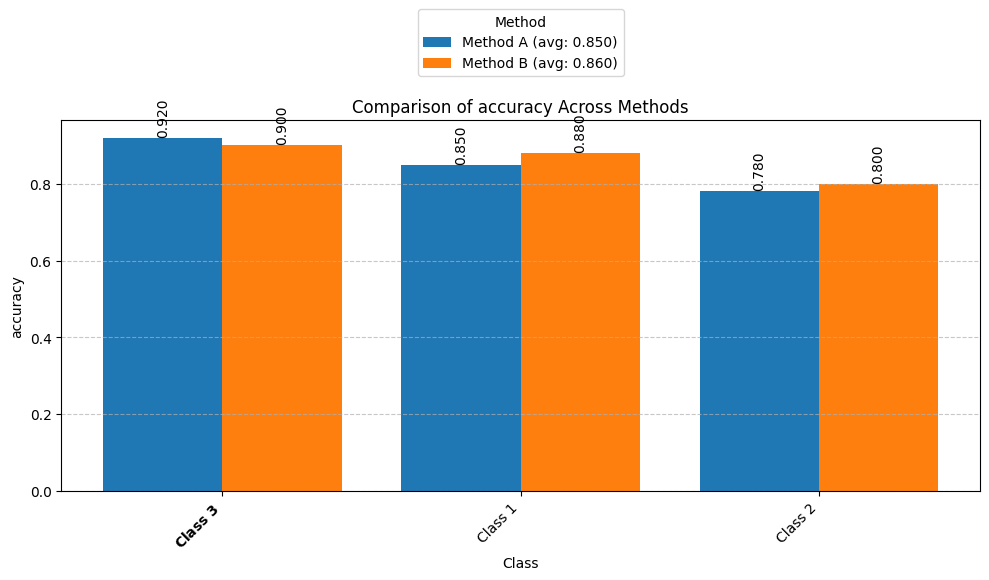

In [137]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_bar_chart(metric_values_list, method_names, metric_name, class_names, horizontal=False, class_names_that_go_first=None,
                          figsize=(10,6), sort_classes_by_average=True, append_average_to_method_name=True):
    if class_names_that_go_first is None:
        class_names_that_go_first = []
        
    if sort_classes_by_average:
        average_scores = np.array(metric_values_list).mean(0)
        sorted_indices = np.argsort(average_scores)[::-1]
        metric_values_list = [[values[i] for i in sorted_indices] for values in metric_values_list]
        class_names = [class_names[i] for i in sorted_indices]
    
    # Ensure class_names_that_go_first is a subset of class_names
    class_names_that_go_first = [c for c in class_names_that_go_first if c in class_names]
    remaining_classes = [c for c in class_names if c not in class_names_that_go_first]
    sorted_class_names = class_names_that_go_first + remaining_classes
    
    # Reorder metric values accordingly
    class_idx_map = {c: i for i, c in enumerate(class_names)}
    sorted_indices = [class_idx_map[c] for c in sorted_class_names]
    metric_values = [[values[i] for i in sorted_indices] for values in metric_values_list]
    
    num_methods = len(metric_values)
    num_classes = len(sorted_class_names)
    
    # Set bar width and spacing
    bar_width = 0.8 / num_methods  # Total width for a group should be less than 1
    spacing = 1.0  # Space between groups
    
    # Compute positions for grouped bars
    indices = np.arange(num_classes) * spacing
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for i, (values, method) in enumerate(zip(metric_values, method_names)):
        offsets = indices + (i - (num_methods - 1) / 2) * bar_width  # Center the groups
        if append_average_to_method_name:
            method = f"{method} (avg: {np.mean(values):.3f})"
        if horizontal:
            bars = ax.barh(offsets, values, height=bar_width, label=method)
            for bar in bars:
                ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center')
        else:
            bars = ax.bar(offsets, values, width=bar_width, label=method)
            for bar in bars:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.3f}', ha='center', rotation=90)
    
    # Set labels and title
    bolded_ticklabels = [fr"$\mathbf{{{c.replace(' ', '~')}}}$" if c in class_names_that_go_first else c for c in sorted_class_names]
    if horizontal:
        ax.set_yticks(indices)
        ax.set_yticklabels(bolded_ticklabels)
        ax.set_xlabel(metric_name)
        ax.set_ylabel("Class")
    else:
        ax.set_xticks(indices)
        ax.set_xticklabels(bolded_ticklabels, rotation=45, ha='right')
        ax.set_ylabel(metric_name)
        ax.set_xlabel("Class")
    
    ax.set_title(f"Comparison of {metric_name} Across Methods")
    ax.grid(axis='x' if horizontal else 'y', linestyle='--', alpha=0.7)
    
    # Adjust legend to be above the plot
    legend = ax.legend(title="Method", loc='lower center', bbox_to_anchor=(0.5, 1.1))
    
    plt.tight_layout()
    plt.show()

# Example usage:
metric_values_list = [
    [0.85, 0.78, 0.92],
    [0.88, 0.80, 0.90],
]
method_names = ["Method A", "Method B"]
class_names = ["Class 1", "Class 2", "Class 3"]
class_names_that_go_first = ["Class 3"]
plot_grouped_bar_chart(metric_values_list, method_names, "accuracy", class_names, horizontal=False, class_names_that_go_first=class_names_that_go_first)

In [60]:
from medvqa.utils.files import get_cached_pickle_file

In [175]:
def plot_auprc_bar_chart(phrase_grounding_metric_paths, multilabel_classification_metric_paths,
                    method_names, phrase_grounding_class_name_order, multilabel_classification_class_name_order,
                    horizontal=True, figsize=(10, 6), class_names_that_go_first=[], sort_classes_by_average=False):

    assert len(phrase_grounding_metric_paths) > 0
    assert len(multilabel_classification_metric_paths) > 0
    assert set(phrase_grounding_class_name_order) == set(multilabel_classification_class_name_order)
    assert len(phrase_grounding_metric_paths) + len(multilabel_classification_metric_paths) == len(method_names)
    mlc_reorder_idxs = [multilabel_classification_class_name_order.index(cn) for cn in phrase_grounding_class_name_order]
    metric_values_list = []
    for mp in phrase_grounding_metric_paths:
        values = load_pickle(mp)['prc_auc']['per_class']
        metric_values_list.append(values)
    for mp in multilabel_classification_metric_paths:
        values = load_pickle(mp)['prc_auc']['per_class']
        values = [values[i] for i in mlc_reorder_idxs] # reorder to match phrase grounding
        metric_values_list.append(values)
    metric_name = 'AUPRC'
    plot_grouped_bar_chart(metric_values_list, method_names, metric_name, phrase_grounding_class_name_order,
                           horizontal=horizontal,figsize=figsize, class_names_that_go_first=class_names_that_go_first,
                           sort_classes_by_average=sort_classes_by_average)

In [95]:
aux = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20250121_034338_vinbig_aehrc-cxrmate-rrg24-uniformer/vinbig_test_set_multilabel_classification_metrics.pkl")

In [111]:
from medvqa.datasets.vinbig import compute_label_frequencies

In [112]:
label_frequenciesequencies = compute_label_frequencies()

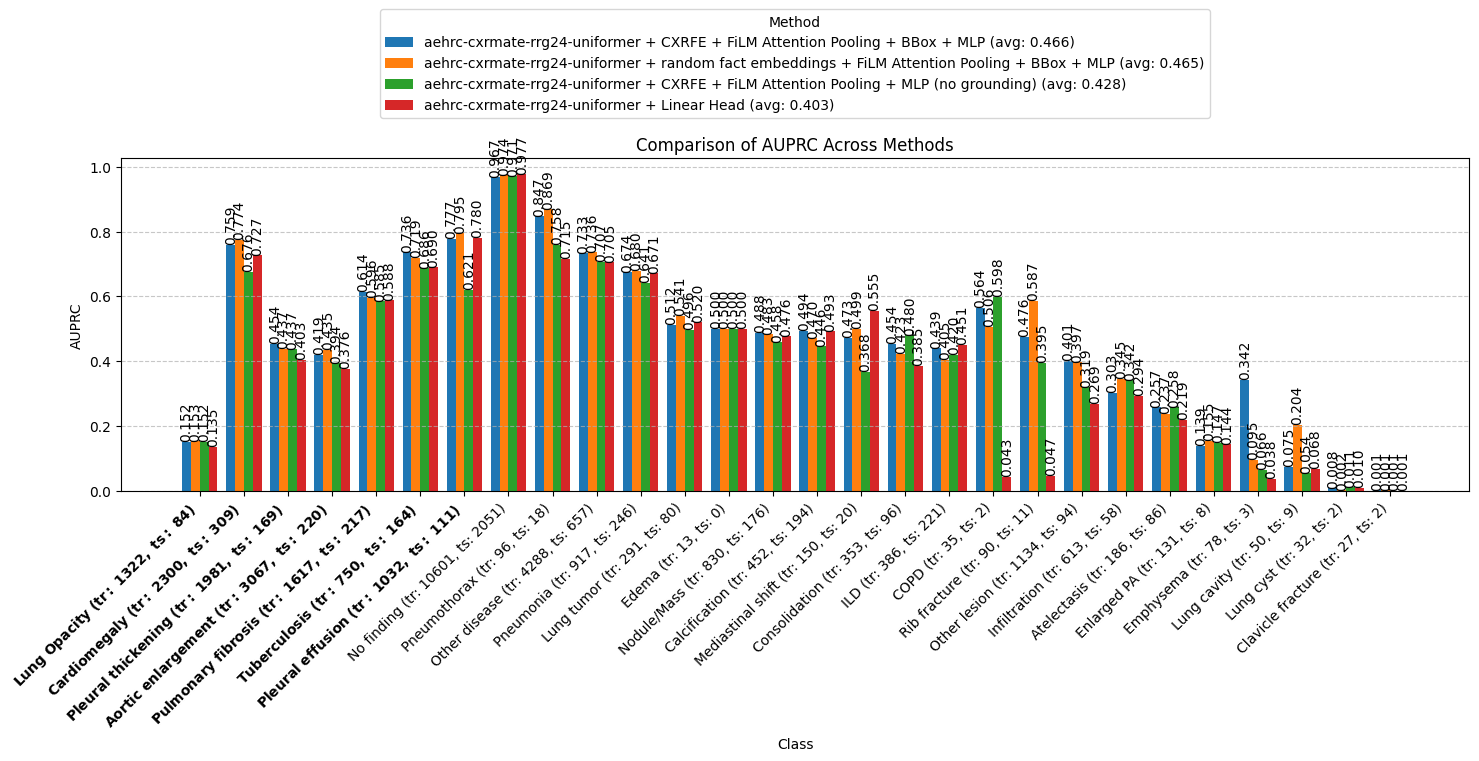

In [139]:
append_frequencies_to_class = lambda x: f'{x} (tr: {label_frequencies["train"][x]}, ts: {label_frequencies["test"][x]})'
phrase_grounding_class_name_order = [
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Clavicle fracture',
    'Consolidation',
    'Edema',
    'Emphysema',
    'Enlarged PA',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Lung cavity',
    'Lung cyst',
    'Mediastinal shift',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
    'Rib fracture',
    'COPD',
    'Lung tumor',
    'Pneumonia',
    'Tuberculosis',
    'Other disease',
    'No finding',
]
phrase_grounding_class_name_order = [append_frequencies_to_class(x) for x in phrase_grounding_class_name_order]
multilabel_classification_class_name_order = [
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Clavicle fracture',
    'Consolidation',
    'Edema',
    'Emphysema',
    'Enlarged PA',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Lung cavity',
    'Lung cyst',
    'Mediastinal shift',
    'Nodule/Mass',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
    'Rib fracture',
    'Other lesion',
    'COPD',
    'Lung tumor',
    'Pneumonia',
    'Tuberculosis',
    'Other disease',
    'No finding',
]
multilabel_classification_class_name_order = [append_frequencies_to_class(x) for x in multilabel_classification_class_name_order]

class_names_that_go_first = [
    "Lung Opacity",
    "Cardiomegaly",
    "Pleural thickening",
    "Aortic enlargement",
    "Pulmonary fibrosis",
    "Tuberculosis",
    "Pleural effusion",
]
class_names_that_go_first = [append_frequencies_to_class(x) for x in class_names_that_go_first]

plot_auprc_bar_chart(
    phrase_grounding_metric_paths=[
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20,50),use_classifier_confs).pkl",
#         "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250130_100205_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.10,0.20),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_134219_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.70),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250130_093100_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)/vindrcxr_metrics(classification,3000).pkl",
    ],
    multilabel_classification_metric_paths=[
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20250121_034338_vinbig_aehrc-cxrmate-rrg24-uniformer/vinbig_test_set_multilabel_classification_metrics.pkl",
    ],
    method_names=[
        "aehrc-cxrmate-rrg24-uniformer + CXRFE + FiLM Attention Pooling + BBox + MLP",
        "aehrc-cxrmate-rrg24-uniformer + random fact embeddings + FiLM Attention Pooling + BBox + MLP",
        "aehrc-cxrmate-rrg24-uniformer + CXRFE + FiLM Attention Pooling + MLP (no grounding)",
        "aehrc-cxrmate-rrg24-uniformer + Linear Head",
    ],
    phrase_grounding_class_name_order=phrase_grounding_class_name_order,
    multilabel_classification_class_name_order=multilabel_classification_class_name_order,
    class_names_that_go_first=class_names_that_go_first,
    figsize=(15, 8),
    horizontal=False,
    sort_classes_by_average=True,
)

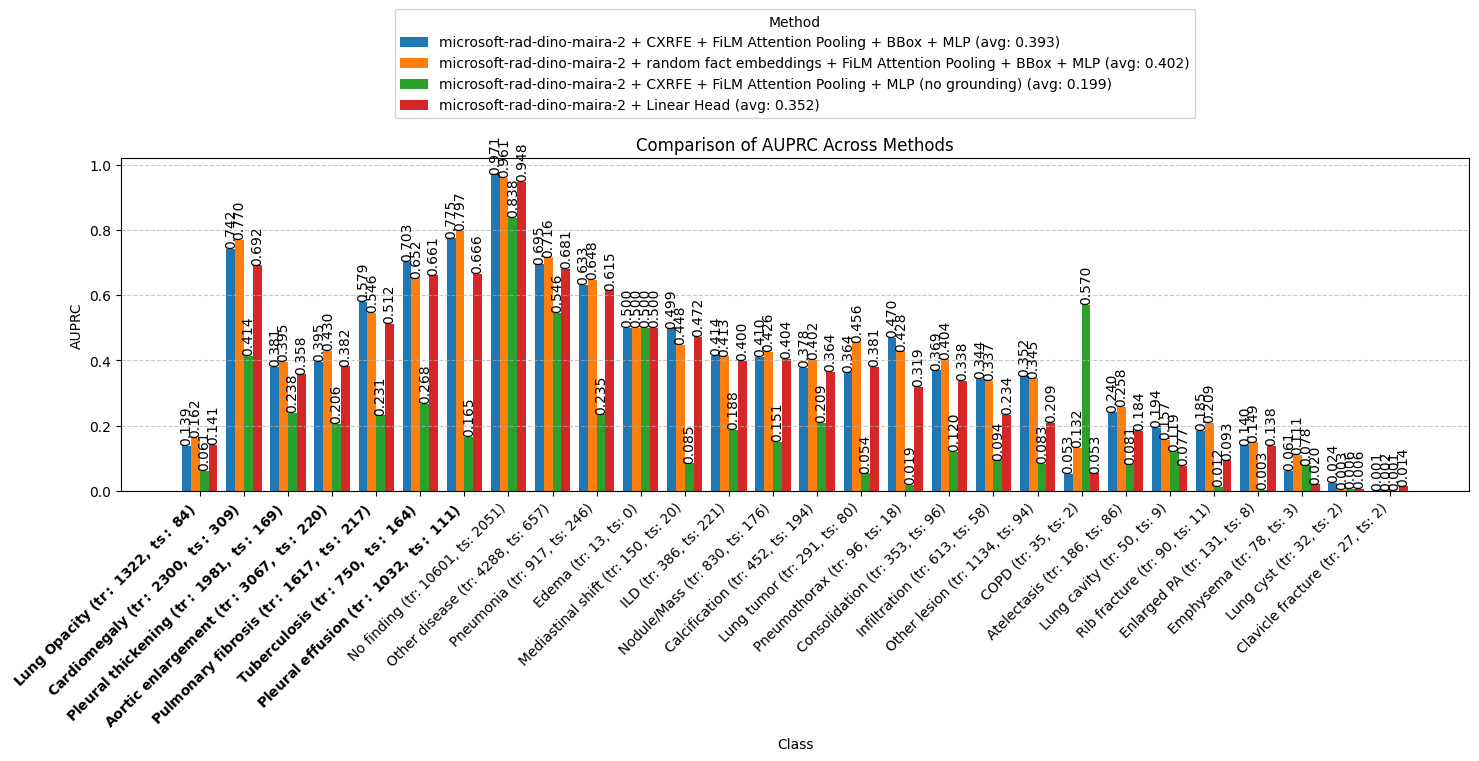

In [140]:
plot_auprc_bar_chart(
    phrase_grounding_metric_paths=[
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10,50),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250130_194227_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250130_192727_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)/vindrcxr_metrics(classification,3000).pkl",
    ],
    multilabel_classification_metric_paths=[
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20250121_093830_vinbig_microsoft-rad-dino-maira-2/vinbig_test_set_multilabel_classification_metrics.pkl",
    ],
    method_names=[
        "microsoft-rad-dino-maira-2 + CXRFE + FiLM Attention Pooling + BBox + MLP",
        "microsoft-rad-dino-maira-2 + random fact embeddings + FiLM Attention Pooling + BBox + MLP",
        "microsoft-rad-dino-maira-2 + CXRFE + FiLM Attention Pooling + MLP (no grounding)",
        "microsoft-rad-dino-maira-2 + Linear Head",
    ],
    phrase_grounding_class_name_order=phrase_grounding_class_name_order,
    multilabel_classification_class_name_order=multilabel_classification_class_name_order,
    class_names_that_go_first=class_names_that_go_first,
    figsize=(15, 8),
    horizontal=False,
    sort_classes_by_average=True,
)

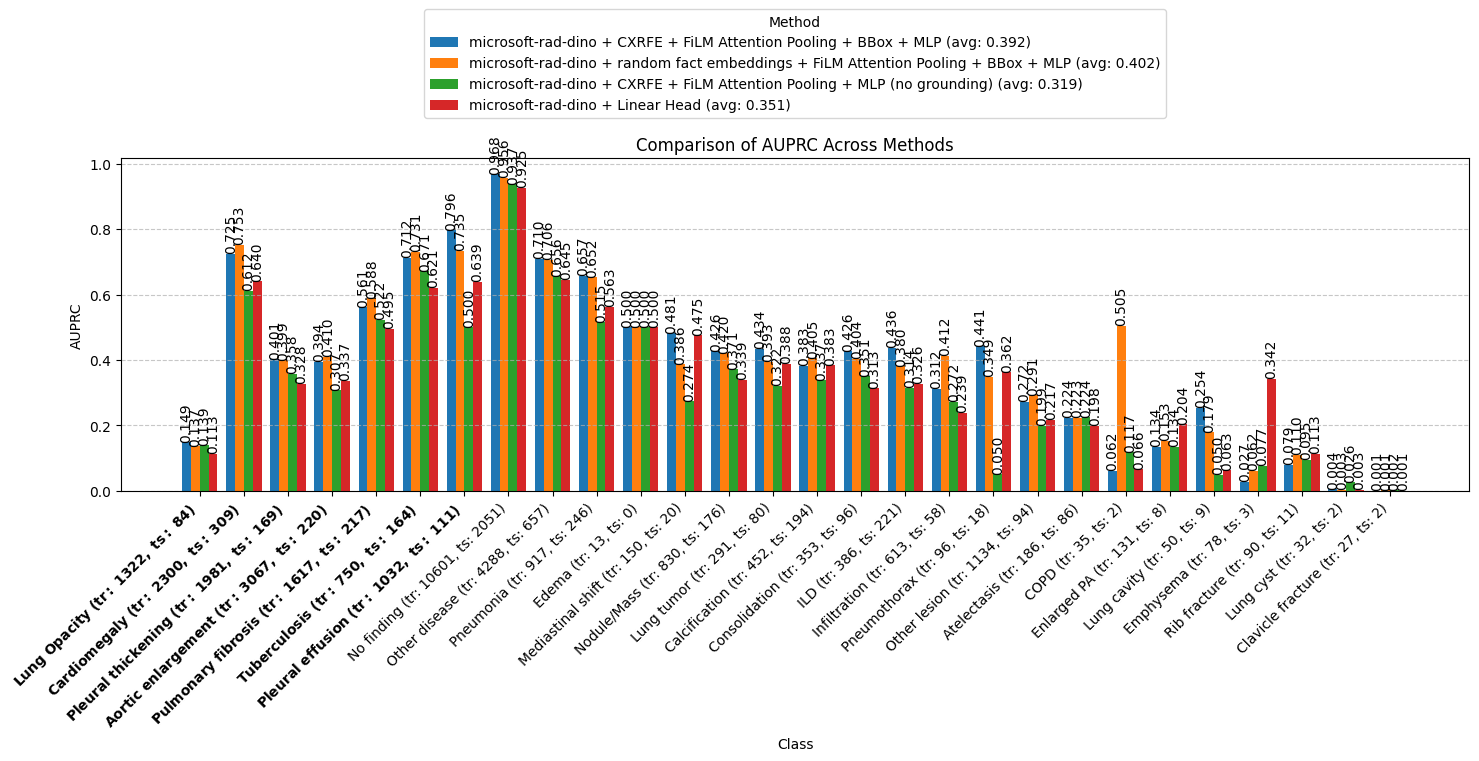

In [141]:
plot_auprc_bar_chart(
    phrase_grounding_metric_paths=[
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_134618_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_014546_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.10),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_022916_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP,128,256,256-128)/vindrcxr_metrics(classification,3000).pkl",
    ],
    multilabel_classification_metric_paths=[
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20250121_052130_vinbig_microsoft-rad-dino/vinbig_test_set_multilabel_classification_metrics.pkl",
    ],
    method_names=[
        "microsoft-rad-dino + CXRFE + FiLM Attention Pooling + BBox + MLP",
        "microsoft-rad-dino + random fact embeddings + FiLM Attention Pooling + BBox + MLP",
        "microsoft-rad-dino + CXRFE + FiLM Attention Pooling + MLP (no grounding)",
        "microsoft-rad-dino + Linear Head",
    ],
    phrase_grounding_class_name_order=phrase_grounding_class_name_order,
    multilabel_classification_class_name_order=multilabel_classification_class_name_order,
    class_names_that_go_first=class_names_that_go_first,
    figsize=(15, 8),
    horizontal=False,
    sort_classes_by_average=True,
)

In [171]:
def plot_mAP_bar_chart(metric_paths, method_names, class_names, horizontal=True, figsize=(10, 6), sort_classes_by_average=False,
                 iou_thresholds=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    
    metric_values_list = []
    for mp in metric_paths:
        results = load_pickle(mp)
        class_aps = compute_mAP__yolov11(
            gt_coords=results['gt_bboxes'],
            pred_boxes=results['pred_boxes_list'],
            pred_classes=results['pred_classes_list'],
            pred_confs=results['pred_confs_list'],
            classifier_confs=results['classifier_confs'],
            iou_thresholds=iou_thresholds,
        )
        print('class_aps.shape =', class_aps.shape)
        values = class_aps.mean(0)
        assert values.shape == (len(VINBIG_BBOX_NAMES),)
        metric_values_list.append(values)
        
    metric_name = f'mAP@[{iou_thresholds[0]}-{iou_thresholds[-1]}]'
    plot_grouped_bar_chart(metric_values_list, method_names, metric_name, class_names,
                           horizontal=horizontal, figsize=figsize, sort_classes_by_average=sort_classes_by_average)

class_aps.shape = (7, 22)
class_aps.shape = (7, 22)
class_aps.shape = (7, 22)
class_aps.shape = (7, 22)
class_aps.shape = (7, 22)
class_aps.shape = (7, 22)


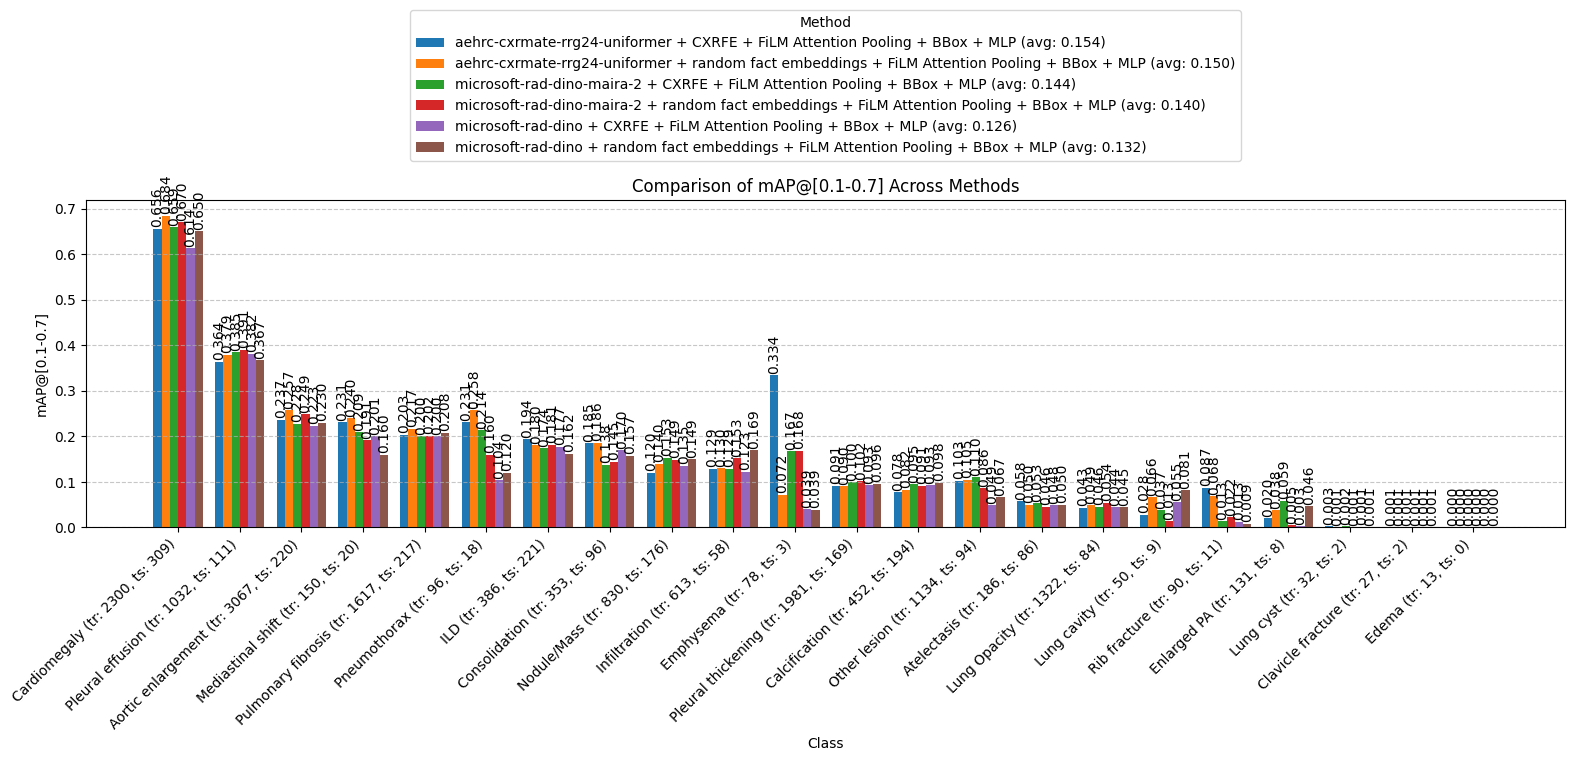

In [174]:
plot_mAP_bar_chart(
    metric_paths=[
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20,50),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_134219_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.70),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10,50),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250130_194227_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_134618_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl",
        "/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250131_014546_vinbig_PhraseGrounder(microsoft-rad-dino,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.10),use_classifier_confs).pkl",
    ],
    method_names=[
        "aehrc-cxrmate-rrg24-uniformer + CXRFE + FiLM Attention Pooling + BBox + MLP",
        "aehrc-cxrmate-rrg24-uniformer + random fact embeddings + FiLM Attention Pooling + BBox + MLP",
        "microsoft-rad-dino-maira-2 + CXRFE + FiLM Attention Pooling + BBox + MLP",
        "microsoft-rad-dino-maira-2 + random fact embeddings + FiLM Attention Pooling + BBox + MLP",
        "microsoft-rad-dino + CXRFE + FiLM Attention Pooling + BBox + MLP",
        "microsoft-rad-dino + random fact embeddings + FiLM Attention Pooling + BBox + MLP",
    ],
    class_names=[append_frequencies_to_class(x) for x in VINBIG_BBOX_NAMES],
    horizontal=False,
    sort_classes_by_average=True,
    figsize=(16, 8),
)